In [16]:
from scipy.stats import dirichlet
import pandas as pd
from pathlib import Path
import numpy as np
import numpy as np
import seaborn as sns
from scipy.stats import entropy
from scipy import stats
import matplotlib.pyplot as plt
import math
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform
import sys
import tensorflow_probability as tfp
    
def label_clusters_by_elbow(val, plot = False, ax = None, std = None):
    '''label clusters by model mean
    val: sorted model mean
    '''
    
    r_square = {}
    reg_params = {}
    for breakpoint in range(1, len(val)-1):
        
        left = val[:breakpoint+1]
        right = val[breakpoint:]
        
        left_x = np.arange(start = 0, stop = len(left), step = 1)
        left_reg = stats.linregress(left_x, left)
        right_x = np.arange(start = breakpoint, stop = breakpoint+len(right), step = 1)
        right_reg = stats.linregress(right_x, right)
        r_square[breakpoint] = left_reg.rvalue**2+right_reg.rvalue**2
        reg_params[breakpoint] = (left_x, left_reg, right_x, right_reg)
        
    elbow_point = max(r_square, key=r_square.get)
    left_x, left_reg, right_x, right_reg = reg_params[elbow_point]
    
    selected = val.iloc[elbow_point+1:]
    #print(val.loc[val-left_y>0].sort_values())
    
    
    if plot:
        if ax is None:
            f, ax = plt.subplots()
        left_x, left_reg, right_x, right_reg = reg_params[elbow_point]
        left_y = left_reg.intercept + left_reg.slope*left_x
        left_y_upper_bound = (left_reg.intercept+ left_reg.intercept_stderr) + (left_reg.slope+left_reg.stderr)*left_x
        left_y_lower_bound = (left_reg.intercept- left_reg.intercept_stderr) + (left_reg.slope-left_reg.stderr)*left_x
        ax.plot(left_x, left_y, 'tomato', label='left regression', lw = 3)
        ax.fill_between(left_x, left_y_upper_bound, left_y_lower_bound, color = 'pink', alpha = 0.5)
        ax.plot(right_x, right_reg.intercept + right_reg.slope*right_x, 'orchid', label='right regression', lw = 3)
        val.plot(marker = '+', color = 'grey', ax = ax, label = 'p_bar')
        if std is not None:
            ax.fill_between(np.arange(len(val)), val+3*std, val-3*std, color = 'skyblue', alpha = 0.5)
        ax.vlines(x = elbow_point, ymax = val.max(), ymin = 0, color = 'black', linestyle='dashed')
        ax.set_xticks(range(len(val)))
        ax.set_xticklabels(val.index, rotation = 90)
        ax.set_ylabel('$bar{p_{jk}}')
        ax.set_title(val.name)
    return selected

def annotate_clusters(model_mean, mapped_reads_fraction, plot = False, model_std=None, fc = 1,
                     ):
    cluster_assignment_df = []
    f, axes = plt.subplots(math.ceil(model_mean.shape[0]/2),2, figsize = (12,16))
    axes = axes.flatten()
    for rbp, ax in zip(model_mean.index, axes):

        val = model_mean.loc[rbp].sort_values()
        if model_std is not None:
            std = model_std.loc[rbp, val.index]
        else:
            std = None
        
        selected = val.ge(mapped_reads_fraction.loc[rbp]*fc)
        selected.name = rbp
        cluster_assignment_df.append(selected)
    ax.legend()
    cluster_assignment_df = pd.concat(cluster_assignment_df, axis = 1).T
    cluster_assignment_df.fillna(False, inplace = True)
    plt.tight_layout()
    sns.despine()
    
    missing_annotation = list(set(model_mean.columns)-set(cluster_assignment_df.columns))
    cluster_assignment_df[missing_annotation]=False
    return cluster_assignment_df.T

def summaries_annotation_and_mean(anno, model_mean, model_var, read_dist):
    ''' create cluster summary statistics '''
    stats = []
    for index, row in anno.iterrows():
        #print(index)
        rbps = row.loc[row].index
        rbps_prefix_free = [r.split('.')[1] for r in rbps]
        mean = model_mean.loc[rbps, index].sum()
        var = model_var.loc[rbps, index].sum()
        bg_mean = read_dist.loc[rbps].sum()
        fc = mean/bg_mean
        
        comp_mean = model_mean[index].copy()
        comp_mean.index = [i.split('.')[1] for i in comp_mean.index]
        ri_contri = (comp_mean*np.log(comp_mean/read_dist))[rbps].sum()
        
        stat = [','.join(rbps_prefix_free), mean, var, bg_mean, fc, ri_contri]
        stats.append(stat)
    return pd.DataFrame(stats, index = anno.index, columns = ['RBP', 'RBP_mean', 'RBP_var', 'background_mean', 'fold_change', 'RI_contribution'])

def count_by_rbp(data_merged, anno, to_count = 'feature_type_top'):
    feature_counts = []
    for rbp in anno.columns:
        cnt = data_merged.loc[data_merged[rbp], to_count].value_counts()
        cnt.name = rbp.split('.')[1]
        feature_counts.append(cnt)
    feature_counts = pd.concat(feature_counts, axis = 1).fillna(0).T
    return feature_counts

def get_counts_by_rbp(data, anno, data_col_to_merge = 'cluster', to_count = 'feature_type_top'):
    ''' count feature types by each RBP '''
    data_merged = data.merge(anno, left_on = data_col_to_merge, right_index = True, how = 'left')
    data_merged[anno.columns] = data_merged[anno.columns].fillna(False)
    
    feature_counts = count_by_rbp(data_merged, anno, to_count = to_count)
    return data_merged, feature_counts

def compute_jaccard_index(identity_tbl):
    ''' use jaccard index to show how much binding site overlapped between RBPs'''
    d_condense = pdist(identity_tbl.T, 'jaccard')
    d = pd.DataFrame(1-squareform(d_condense), index = identity_tbl.columns, columns = identity_tbl.columns)
    return d


class Dirichlet_Mixture_Model:
    def __init__(self, alphas, weights, n):
        
        self.alphas = alphas # (alpha, beta) of each component, K*2 matrix
        self.weights = weights # vector of length K
        self.n = n
        
        self.distributions = []
        
        for a in self.alphas:
            self.distributions.append(tfp.distributions.DirichletMultinomial(n, a))
    def pmf(self,k):
        ''' return pmf of  mixture model'''
        p = 0
        for w, dist in zip(self.weights, self.distributions):
            p += w*dist.prob(k)
        return p
    
    def cdf(self,k):
        raise NotImplementedError
    def logpmf(self,k):
        return np.log(self.pmf(k))
    def pvalue(self,k):
        raise NotImplementedError

def DMM_bayes_factor(model_alphas, weights, rbps, components, raw_data, plot = True, nread = 30):
    '''dirichlet multinomial mixture log likelihood (BF) by aggregation property
    aggregate all the other proteins as noise
    calculate P(X|alt)/P(X|null)
    '''
    
    if weights.index[0] in model_alphas.columns:
        model_alphas.columns = [f'alpha.{c}' for c in model_alphas.columns]
    
    # marginalize into [rbp], [other]
    marginalized_alphas = pd.concat([model_alphas.loc[rbps].T, 
                                 model_alphas.loc[~model_alphas.index.isin(rbps)].sum(axis = 0)],
                               axis = 1)
    
    marginalized_counts = pd.concat([raw_data[rbps], 
                                 raw_data.loc[:, ~raw_data.columns.isin(rbps)].sum(axis = 1)],
                               axis = 1)
    
    
    comp_names = weights.loc[components].index # [V22]
    other_names = weights.loc[~weights.index.isin(components)].index # [all other comp]
    
    if 'alpha' in model_alphas.columns[0]:
        comp_names_alpha= [f'alpha.{c}' for c in comp_names]
        other_names_alpha = [f'alpha.{c}' for c in other_names]
    
    # reweight
    alt_w = weights.loc[comp_names, 'pi']
    alt_w = alt_w/alt_w.sum()
    alt = Dirichlet_Mixture_Model(marginalized_alphas.loc[comp_names_alpha].values,
                             alt_w,
                            n = marginalized_counts.sum(axis = 1).astype(float))
    
    
    null_w = weights.loc[other_names, 'pi']
    null_w = null_w/null_w.sum()
    null = Dirichlet_Mixture_Model(marginalized_alphas.loc[other_names_alpha].values,
                             null_w,
                             n = marginalized_counts.sum(axis = 1).astype(float))
    
    logL_comp = np.log(alt.pmf(marginalized_counts))
    logL_null = np.log(null.pmf(marginalized_counts))
    
    
    logLR = logL_comp-logL_null
    
    bf_df = pd.DataFrame([logL_null, logL_comp, logLR], 
                         index = ['logL_singlecomp', 'logL_comp', 'logLR'], 
                         columns = raw_data.index).T
    
    
    return bf_df

def filter_by_bf(bfs, individual_bfs, data, anno, comp_mapping = None, logbf_thres = 2):
    ''' filter hypothesis assignment by hypothesis-wise BF and individual BF 
    hypothesis BF: ex, How likely is this window being SF3B4+PRPF8 instead of all other hypothesis (including SF3B4 sole binding and PRPF8 sole binding)
    individual BF: ex, How likely is this window bound by SF3B4 (regardless of other partners' present) vs not being bound at all?
    '''
    data = data.copy()
    
    # filtering for combinatorial binding
    for index, row in data.iterrows():
        clus = row['cluster']
        if comp_mapping:
            try:
                evi = bfs.loc[index, comp_mapping[clus]]
                rbps = anno.loc[comp_mapping[clus]][anno.loc[comp_mapping[clus]]].index
            except:
                evi = 0
                rbps = []
        else:
            try:
                evi = bfs.loc[index, clus]
                rbps = anno.loc[clus][anno.loc[clus]].index
            except:
                evi = 0 # some of the clusters are not there anymore
                rbps = []
        
        if individual_bfs.loc[index, rbps].ge(logbf_thres).all():
            # if all RBPs are bound for specific component
            data.loc[index, 'logLR']=evi
        else:
            data.loc[index, 'logLR']=0 # individual RBPs don't have evidence
        
        
        
    data.loc[data['logLR']>logbf_thres, 'BF_assignment'] = data.loc[data['logLR']>logbf_thres, 'cluster']
    
    data_merged, feature_counts = get_counts_by_rbp(data, anno, data_col_to_merge = 'BF_assignment')
    
    # rescue individual binding sites that were that detected by any hypothesis
    not_assigned = data_merged.loc[data_merged['BF_assignment'].isnull()]
    return data_merged, feature_counts

def mask_megaoutput(megaoutputs, mask):
    '''
    take megaoutput, modify logLR:{RBP} and binary {RBP} labels based on log_cdf and mask
    mask: True or false based on whether y_dev > zscore_cutoff * stdev
    '''
    # binary labels are gone
    megaoutputs_masked = megaoutputs.copy()
    common_index = list(set(megaoutputs_masked.index).intersection(set(mask.index)))
    megaoutputs_masked.loc[common_index, mask.columns] = megaoutputs.loc[common_index, mask.columns] & mask # being logLR > 2 and >2*stdev
    
    return megaoutputs_masked



In [14]:

'''
cd /home/hsher/scratch/ABC_2rep/
conda activate tensorflow_prob
python /tscc/nfs/home/hsher/Mudskipper/scripts/analyze_DMM.py K562_rep6.1
'''

out_stem = 'K562_rep6'
basedir = Path('/tscc/nfs/home/hsher/ps-yeolab5/ABC_2rep_rerun/')
dmm_param_dir = Path('/tscc/nfs/home/hsher//ps-yeolab5/DMM_K_params/')

def analyze_dmm_prefix(dmm_param_dir, dmm_prefix, fc_raw_thres = 1):

    # constants
    logLR_threshold = 2
    ent_thres = 0.1
    
    
    # fitted parameters and outputs
    data = pd.read_csv(dmm_param_dir/f'DMM/{dmm_prefix}.mixture_weight.tsv', sep = '\t', index_col = 0) # basedir/f'DMM/{out_stem}.mixture_weight.tsv'
    data.set_index('Row.names', inplace = True)
    
    mixture_weight_only = data.loc[:, data.columns.str.startswith('V')]
    mixture_weight_only.columns
    data['cluster']=mixture_weight_only.idxmax(axis = 1)
    
    weights = pd.read_csv(dmm_param_dir/f'DMM/{dmm_prefix}.weights.tsv', sep = '\t', index_col = 0)
    weights.index = [f'V{i}' for i in weights.index]
    
    model_alphas = pd.read_csv(dmm_param_dir/f'DMM/{dmm_prefix}.alpha.tsv', sep = '\t',
                        index_col = 0) # RBP by components, B * K
    model_alphas.columns = [i.replace('X', 'V') for i in model_alphas.columns]
    model_mean = model_alphas.div(model_alphas.sum(axis = 0), axis = 1)
    model_var = model_alphas.apply(lambda column: dirichlet(column).var(), axis = 0)
    model_std = np.sqrt(model_var)

    
    
    # masks
    mask = pd.read_csv(basedir / 'mask' / f'{out_stem}.genome_mask.csv', index_col = 0)
    
    # raw_counts to calculate bayes factor
    raw_counts = pd.read_csv(basedir /f'counts/genome/megatables/{out_stem}.tsv.gz', sep = '\t')
    raw_counts.index = raw_counts.index+1
    raw_counts = raw_counts.loc[data.index] # filter for those that has been modelled (passing the total_read_threshold)
    
    # find total mapped reads as the null
    nread_per_window = raw_counts.sum(axis = 1)
    mapped_reads = raw_counts.sum(axis = 0)
    mapped_reads_fraction = mapped_reads.div(mapped_reads.sum())
    print('========Fraction mapped reads: \n ========',mapped_reads_fraction.sort_values())
    
    # visualization
    sns.clustermap(model_mean.T,
            cbar_kws = {'label': '\bar{p}'},
            metric = 'correlation', cmap = 'Greys', figsize = (4,4))
    plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.model_mean.pdf')
    
    
    # calculate FC over null for each component
    component_fc = (model_mean).div(mapped_reads_fraction, axis = 0).T
    # visualization
    sns.clustermap(component_fc,
            cbar_kws = {'label': 'FC over total mapped reads'},
            metric = 'correlation', cmap = 'Greys', figsize = (4,4))
    plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.component_fc.pdf')
    
    # annotate cluster: elbow method.
    # anno = annotate_clusters(model_mean, plot = True, model_std = model_std)
    anno = component_fc.ge(fc)
    plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.elbow_labelling.pdf')
    
    # calculate entropy and filter, summarize clusters
    ent = model_mean.apply(lambda col: entropy(col, mapped_reads_fraction), axis = 0).sort_values()
    
    # masked
    data['contain_mask'] = data.index.isin(mask.index)
    fraction_mask = data.groupby(by = 'cluster')['contain_mask'].mean()
    
    # summarize clusters
    f, ax = plt.subplots(1,3, figsize = (12,4))
    annotation_summary = pd.concat([anno.sum(axis = 1), ent, fraction_mask], axis = 1)
    annotation_summary.columns = ['# RBP assigned', 'RI to total read distribution', 'fraction contain windows needing softmask']
    
    comp_stats = summaries_annotation_and_mean(anno, model_mean, model_var, mapped_reads_fraction)
    annotation_summary = comp_stats.merge(annotation_summary, left_index = True, right_index = True)
    annotation_summary['# RBP assigned'].sort_values().plot.barh(ax = ax[0], color = 'grey')
    
    annotation_summary['RI to total read distribution'].sort_values().plot.barh(ax = ax[1], color = 'grey')
    ax[1].set_ylabel('# relative entropy to\n  total reads distribution')
    sns.despine()
    
    anno.sum(axis = 0).sort_values().plot.barh(ax = ax[2], color = 'grey')
    ax[2].set_ylabel('# clusters assigned')
    plt.tight_layout()
    plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.cluster_summary.pdf')
    
    # low entropy is bad: should not filter because it still contains some individual binding sites
    # too_low_entropy = ent[ent<0.1].index.tolist()
    # annotation_summary['filtered']=annotation_summary.index.isin(too_low_entropy)
    # anno.loc[anno.index.isin(too_low_entropy)] = False
    
    annotation_summary.to_csv(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.cluster_summary.csv')
    anno.to_csv(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.cluster_annotation_binary.csv')
    
    # calculate effect size: p_bar, fc_bar and p_bar's std
    ezik = data[model_mean.columns]
    p_bar = np.matmul(ezik, model_mean.T)
    p_bar.columns = model_mean.index
    p_raw = raw_counts.div(nread_per_window, axis = 0)
    fc_bar = p_bar.div(mapped_reads_fraction, axis = 1)
    fc_raw = p_raw.div(mapped_reads_fraction, axis = 1)
    
    var_bar = np.matmul(ezik, model_var.T)
    var_bar.columns = model_var.index
    std_bar = np.sqrt(var_bar)
    
    p_bar.to_csv(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.p_bar.csv')
    p_raw.to_csv(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.p_raw.csv')
    fc_bar.to_csv(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.fc_bar.csv')
    fc_raw.to_csv(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.fc_raw.csv')
    std_bar.to_csv(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.p_bar_std.csv')
    
    # plot model fit for p_bar and p_raw
    f, axes = plt.subplots(2, math.ceil(p_bar.shape[1]/2), figsize = (8, 5))
    axes = axes.flatten()
    
    for col, ax in zip(p_bar.columns, axes):
        ax.scatter(p_raw[col], p_bar.loc[p_raw.index, col], color = 'lightgrey', marker = '+')
        r, pval = pearsonr(p_raw[col], p_bar.loc[p_raw.index, col])
        ax.set_ylabel('p_bar_i')
        ax.set_xlabel('p_raw')
        ax.set_title(f'{col}\n r={r:.2f}\n p={pval:.2E}')
    sns.despine()
    plt.tight_layout()
    plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.p_fit.pdf')
    
    # visualize regions distribution for each cluster
    col = 'feature_type_top'
    cluster_count = data.pivot_table(index = 'cluster', columns = col, 
                                fill_value=0, aggfunc='size')
    cluster_frac = cluster_count.div(cluster_count.sum(axis = 1), axis = 0)
    
    anno_as_color = anno.applymap(lambda ans: 'royalblue' if ans else 'white')
    anno_as_color.columns = [c.split('.')[1]+'(labels)' for c in anno_as_color.columns]
    sns.clustermap(cluster_frac*100,
            cmap = 'Greys', metric = 'cosine', cbar_kws ={'label': '%window', }, cbar_pos = (1,0.2,0.02,0.6),
            figsize = (5,6), xticklabels = 1, yticklabels = 1,
            row_colors = anno_as_color.T.sort_index().T)
    plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.cluster_region_type.pdf')
    cluster_count.to_csv(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.cluster_region_type.csv')
    
    # Calculate Bayes Factor (hypothesis wise)
    comp_mapping = {}
    bfs_dmm = []
    for name, group in anno.groupby(by = list(anno.columns)):
        components = list(group.index)
        rbps = anno.columns[list(name)].tolist()
        if sum(name) > 0:
            print(components, rbps)
            bf_df = DMM_bayes_factor(model_alphas, weights, rbps, components, raw_counts)['logLR']
            bf_df.name = components[0]
            for comp in components:
                comp_mapping[comp]=components[0]
            bfs_dmm.append(bf_df)
    
    bfs_dmm = pd.concat(bfs_dmm, axis = 1)
    
    individual_bfs_dmm = []
    
    # test individual RBPs' binding
    for rbp in anno.columns:
        bound_components = anno[rbp][anno[rbp]].index
        print(bound_components)
        if len(bound_components)>0:
            individual_LR = DMM_bayes_factor(model_alphas, weights, [rbp], bound_components, raw_counts)['logLR']
        else:
            individual_LR = pd.Series(index = ezik.index)
        individual_LR.name = rbp
        individual_bfs_dmm.append(individual_LR)
    
    individual_bfs_dmm = pd.concat(individual_bfs_dmm, axis = 1)
    bfs_dmm.to_csv(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.BF_hypothesis.csv')
    individual_bfs_dmm.to_csv(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.BF_individual.csv') 
    
    # ====== By Hypothesis =====
    data_bf_dmm, dmm_fcount = filter_by_bf(bfs_dmm, individual_bfs_dmm, data = data, anno = anno, comp_mapping = comp_mapping)
    dmm_fcount.to_csv(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.rbp_region_type.BF_filtered.csv')
    
    # calculate jaccard index
    if not data_bf_dmm[anno.columns].sum(axis = 0).ge(1).all():
        # if not everything has at least 1 binding site
        cols_to_plot = anno.columns[data_bf_dmm[anno.columns].sum(axis = 0).ge(1)]
    else:
        cols_to_plot = anno.columns
    
    if len(cols_to_plot)>1:
        d_dmm = compute_jaccard_index(data_bf_dmm[anno.columns])
        cm=sns.clustermap(d_dmm, cmap = 'Greys', metric = 'correlation', figsize = (4,4),
                    vmax = 1)
        cm.cax.set_visible(False)
        plt.suptitle('ABC(Dirichlet Mixture Model: BF filtered)', y = 1)
        plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.jaccard_index.pdf')
    else:
        print('RBP with binding site:', cols_to_plot)
    
    # count RBP
    try:
        sns.set_palette('tab20c')
        plt.style.use('seaborn-white')
        dmm_fcount.plot.barh(stacked = True)
        dmm_fcount.to_csv(basedir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.rbp_region_type.csv')
        sns.despine()
        plt.xlabel('# windows')
        plt.legend(bbox_to_anchor=(1.2,1))
        plt.tight_layout()
        plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.region_type_count_by_hypothesis_RBPwise.pdf')
    except Exception as e:
        print('Fail to plot *_rbp_region_type', e)
    
    # count by hypothesis
    try:
        fcount_by_hypothesis = data_bf_dmm.groupby(by = ['BF_assignment'])['feature_type_top'].value_counts().unstack().fillna(0)
        fcount_by_hypothesis.index = fcount_by_hypothesis.index.map(lambda component: component+':'+','.join(
            [r.split('.')[1] for r in anno.columns[anno.loc[component]].tolist()]))
        fcount_by_hypothesis.to_csv(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.hypothesis_region_type.csv')
        fcount_by_hypothesis.plot.barh(stacked = True)
        sns.despine()
        plt.legend(bbox_to_anchor=(1.2,1))
        plt.xlabel('# windows')
        plt.tight_layout()
        plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.region_type_count_by_hypothesis.pdf')
    except Exception as e:
        print('Fail to plot *_hypothesis_region_type', e)
    
    # ====== By Individual RBPs ======
    data_bf_dmm.loc[individual_bfs_dmm.index, anno.columns]=individual_bfs_dmm.ge(logLR_threshold)
    
    # perform masking
    data_bf_dmm['name'] = data_bf_dmm.index
    data_bf_dmm_masked = mask_megaoutput(data_bf_dmm, mask)
    
    
    
    # jaccard index
    try:
        d_dmm = compute_jaccard_index(data_bf_dmm_masked.loc[:, data_bf_dmm_masked.columns.str.startswith(out_stem)])
        cm=sns.clustermap(d_dmm, cmap = 'Greys', metric = 'correlation', figsize = (4,4),
                    vmax = 0.3)
        cm.cax.set_visible(False)
        plt.suptitle('ABC(Dirichlet Mixture Model: individual BF)', y = 1)
    
        indiv_assignment_fcount_unmasked = count_by_rbp(data_bf_dmm, anno)
        indiv_assignment_fcount = count_by_rbp(data_bf_dmm_masked, anno)
        indiv_assignment_fcount.to_csv(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.region_type_count_by_individual.csv')
        indiv_assignment_fcount.T.sort_index().T.plot.barh(stacked = True)
        sns.despine()
        plt.legend(bbox_to_anchor=(1,1))
        plt.xlabel('# genomic window')
        plt.tight_layout()
        plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.region_type_count_by_individual.pdf')
        
        # plot masked: region type
        f, axes = plt.subplots(1,2, sharex = True, sharey = True, figsize = (6,3))
        diff = (indiv_assignment_fcount_unmasked-indiv_assignment_fcount).fillna(0)
        diff = (indiv_assignment_fcount_unmasked-indiv_assignment_fcount).fillna(0)
        diff.loc[diff.sum(axis =1).sort_values().index, diff.sum(axis = 0)>0].plot.barh(
            stacked = True, ax = axes[0])
        diff.to_csv(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.region_type_masked.csv')
        
        
        # plot masked: transcript type
        indiv_assignment_fcount = count_by_rbp(data_bf_dmm_masked, anno, to_count = 'transcript_type_top')
        indiv_assignment_fcount_unmasked = count_by_rbp(data_bf_dmm, anno, to_count = 'transcript_type_top')
        diff = (indiv_assignment_fcount_unmasked-indiv_assignment_fcount).fillna(0)
        diff.loc[diff.sum(axis =1).sort_values().index, diff.sum(axis = 0)>0].plot.barh(
            stacked = True, ax = axes[1])
        diff.to_csv(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.transcript_type_masked.csv')
        sns.despine()
        ax[0].legend(bbox_to_anchor=(1,1))
        ax[1].legend(bbox_to_anchor=(1,1))
        plt.xlabel('# genomic window masked')
        plt.tight_layout()
        plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.region_type_masked.pdf')
        
    except Exception as e:
        print('Fail to plot jaccard and region_type', e)
    
        # ====== Generate Output ======
        # --- output by individual RBP ---
        columns = ['chrom', 'start', 'end', 'name', 'score',
        'strand', 'feature_id', 'feature_bin', 'feature_type_top',
        'feature_types', 'gene_name', 'gene_id', 'transcript_ids',
        'gene_type_top', 'transcript_type_top', 'gene_types',
        'transcript_types','logLR', 'BF_assignment',]
        # output per RBP enrich windows
    
    for c in anno.columns:
    
        enriched_windows = data_bf_dmm_masked.loc[data_bf_dmm_masked[c], columns]
        enriched_windows['p_bar']=p_bar[c]
        enriched_windows['p_raw']=p_raw[c]
        enriched_windows['fc_raw']=fc_raw[c]
        enriched_windows['fc_bar']=fc_bar[c]
        enriched_windows['p_bar_std']=std_bar[c]
        enriched_windows.to_csv(dmm_param_dir / 'DMM'/ f'{c}.enriched_windows.tsv', sep = '\t')
        print(f'found {c} enriched windows:', enriched_windows.shape)
    
    # --- output everything ---
    # output the full data
    p_bar.columns=[f'p_bar:{c}' for c in p_bar.columns]
    p_raw.columns=[f'p_raw:{c}' for c in p_raw.columns]
    fc_raw.columns=[f'fc_raw:{c}' for c in fc_raw.columns]
    fc_bar.columns=[f'fc_bar:{c}' for c in fc_bar.columns]
    std_bar.columns=[f'p_bar_std:{c}' for c in std_bar.columns]
    individual_bfs_dmm.columns=[f'logLR:{c}' for c in individual_bfs_dmm.columns]
    
    # concat everything and write together
    megaoutput = pd.concat([data_bf_dmm_masked, p_bar, p_raw, fc_raw, fc_bar, std_bar, individual_bfs_dmm], axis = 1)
    megaoutput.to_csv(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.megaoutputs.tsv', sep = '\t')
    
    data_bf_dmm.to_csv(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.megaoutputs_unmasked.tsv', sep = '\t')
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    


========Fraction mapped reads: 
 ======== K562_rep6.PUM2       0.012202
K562_rep6.EIF3G      0.021944
K562_rep6.ZC3H11A    0.046280
K562_rep6.DDX3       0.052620
K562_rep6.LIN28B     0.061494
K562_rep6.SF3B4      0.082945
K562_rep6.IGF2BP2    0.101528
K562_rep6.PRPF8      0.123238
K562_rep6.RBFOX2     0.125049
K562_rep6.FAM120A    0.372699
dtype: float64


/tscc/nfs/home/hsher/miniconda3/envs/tensorflow_prob/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8 ) missing from current font.
  fig.canvas.draw()
/tmp/ipykernel_3525948/1622931377.py:56: UserWarning: Glyph 8 ) missing from current font.
  plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.model_mean.pdf')
/tmp/ipykernel_3525948/1622931377.py:56: UserWarning: Glyph 8 ) missing from current font.
  plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.model_mean.pdf')
/tmp/ipykernel_3525948/1622931377.py:107: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') be

['V35'] ['K562_rep6.SF3B4']
['V38'] ['K562_rep6.LIN28B']
['V9', 'V16', 'V25'] ['K562_rep6.PRPF8', 'K562_rep6.SF3B4']
['V18'] ['K562_rep6.PRPF8', 'K562_rep6.LIN28B', 'K562_rep6.SF3B4']
['V13'] ['K562_rep6.DDX3', 'K562_rep6.EIF3G', 'K562_rep6.LIN28B', 'K562_rep6.SF3B4']
['V1', 'V2', 'V4', 'V11'] ['K562_rep6.FAM120A']
['V29'] ['K562_rep6.FAM120A', 'K562_rep6.LIN28B']
['V12'] ['K562_rep6.FAM120A', 'K562_rep6.DDX3', 'K562_rep6.ZC3H11A', 'K562_rep6.EIF3G', 'K562_rep6.LIN28B']
['V37'] ['K562_rep6.PUM2', 'K562_rep6.ZC3H11A', 'K562_rep6.PRPF8', 'K562_rep6.SF3B4']
['V39'] ['K562_rep6.PUM2', 'K562_rep6.DDX3', 'K562_rep6.EIF3G']
['V40'] ['K562_rep6.PUM2', 'K562_rep6.DDX3', 'K562_rep6.ZC3H11A', 'K562_rep6.EIF3G', 'K562_rep6.LIN28B', 'K562_rep6.SF3B4']
['V20', 'V21'] ['K562_rep6.RBFOX2']
['V17', 'V22', 'V41'] ['K562_rep6.RBFOX2', 'K562_rep6.PRPF8', 'K562_rep6.SF3B4']
['V3'] ['K562_rep6.RBFOX2', 'K562_rep6.PRPF8', 'K562_rep6.LIN28B', 'K562_rep6.SF3B4']
['V28'] ['K562_rep6.RBFOX2', 'K562_rep6.EIF3G']


/tmp/ipykernel_3525948/1622931377.py:209: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
/tmp/ipykernel_3525948/1622931377.py:230: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Fail to plot jaccard and region_type 'Axes' object is not subscriptable
found K562_rep6.IGF2BP2 enriched windows: (10986, 24)
found K562_rep6.RBFOX2 enriched windows: (11895, 24)
found K562_rep6.PUM2 enriched windows: (569, 24)
found K562_rep6.FAM120A enriched windows: (42954, 24)
found K562_rep6.DDX3 enriched windows: (5474, 24)
found K562_rep6.ZC3H11A enriched windows: (2711, 24)
found K562_rep6.EIF3G enriched windows: (1586, 24)
found K562_rep6.PRPF8 enriched windows: (32990, 24)
found K562_rep6.LIN28B enriched windows: (10022, 24)
found K562_rep6.SF3B4 enriched windows: (18775, 24)
========Fraction mapped reads: 
 ======== K562_rep6.PUM2       0.012202
K562_rep6.EIF3G      0.021944
K562_rep6.ZC3H11A    0.046280
K562_rep6.DDX3       0.052620
K562_rep6.LIN28B     0.061494
K562_rep6.SF3B4      0.082945
K562_rep6.IGF2BP2    0.101528
K562_rep6.PRPF8      0.123238
K562_rep6.RBFOX2     0.125049
K562_rep6.FAM120A    0.372699
dtype: float64


/tscc/nfs/home/hsher/miniconda3/envs/tensorflow_prob/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8 ) missing from current font.
  fig.canvas.draw()
/tmp/ipykernel_3525948/1622931377.py:56: UserWarning: Glyph 8 ) missing from current font.
  plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.model_mean.pdf')
/tmp/ipykernel_3525948/1622931377.py:56: UserWarning: Glyph 8 ) missing from current font.
  plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.model_mean.pdf')
/tmp/ipykernel_3525948/3142850990.py:98: RuntimeWarning: invalid value encountered in scalar divide
  fc = mean/bg_mean
/tmp/ipykernel_3525948/1622931377.py:107: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy arra

['V35'] ['K562_rep6.SF3B4']
['V33', 'V38'] ['K562_rep6.LIN28B']
['V3', 'V9'] ['K562_rep6.PRPF8']
['V16', 'V22', 'V25'] ['K562_rep6.PRPF8', 'K562_rep6.SF3B4']
['V18'] ['K562_rep6.PRPF8', 'K562_rep6.LIN28B']
['V37'] ['K562_rep6.ZC3H11A']
['V13', 'V39'] ['K562_rep6.DDX3', 'K562_rep6.EIF3G']
['V15'] ['K562_rep6.DDX3', 'K562_rep6.EIF3G', 'K562_rep6.LIN28B']
['V5'] ['K562_rep6.DDX3', 'K562_rep6.EIF3G', 'K562_rep6.PRPF8', 'K562_rep6.LIN28B', 'K562_rep6.SF3B4']
['V1', 'V2', 'V4', 'V11'] ['K562_rep6.FAM120A']
['V29'] ['K562_rep6.FAM120A', 'K562_rep6.LIN28B']
['V36'] ['K562_rep6.FAM120A', 'K562_rep6.ZC3H11A']
['V27'] ['K562_rep6.PUM2', 'K562_rep6.DDX3', 'K562_rep6.ZC3H11A', 'K562_rep6.EIF3G', 'K562_rep6.SF3B4']
['V40'] ['K562_rep6.PUM2', 'K562_rep6.DDX3', 'K562_rep6.ZC3H11A', 'K562_rep6.EIF3G', 'K562_rep6.LIN28B', 'K562_rep6.SF3B4']
['V32'] ['K562_rep6.PUM2', 'K562_rep6.FAM120A']
['V20', 'V21', 'V26', 'V28'] ['K562_rep6.RBFOX2']
['V41'] ['K562_rep6.RBFOX2', 'K562_rep6.SF3B4']
['V7', 'V17'] ['K56

/tmp/ipykernel_3525948/1622931377.py:209: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
/tscc/nfs/home/hsher/miniconda3/envs/tensorflow_prob/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


Fail to plot jaccard and region_type 'Axes' object is not subscriptable
found K562_rep6.IGF2BP2 enriched windows: (11297, 24)
found K562_rep6.RBFOX2 enriched windows: (10868, 24)
found K562_rep6.PUM2 enriched windows: (896, 24)
found K562_rep6.FAM120A enriched windows: (38461, 24)
found K562_rep6.DDX3 enriched windows: (5824, 24)
found K562_rep6.ZC3H11A enriched windows: (3208, 24)
found K562_rep6.EIF3G enriched windows: (1836, 24)
found K562_rep6.PRPF8 enriched windows: (29540, 24)
found K562_rep6.LIN28B enriched windows: (9217, 24)
found K562_rep6.SF3B4 enriched windows: (9782, 24)
========Fraction mapped reads: 
 ======== K562_rep6.PUM2       0.012202
K562_rep6.EIF3G      0.021944
K562_rep6.ZC3H11A    0.046280
K562_rep6.DDX3       0.052620
K562_rep6.LIN28B     0.061494
K562_rep6.SF3B4      0.082945
K562_rep6.IGF2BP2    0.101528
K562_rep6.PRPF8      0.123238
K562_rep6.RBFOX2     0.125049
K562_rep6.FAM120A    0.372699
dtype: float64


/tscc/nfs/home/hsher/miniconda3/envs/tensorflow_prob/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8 ) missing from current font.
  fig.canvas.draw()
/tmp/ipykernel_3525948/1622931377.py:56: UserWarning: Glyph 8 ) missing from current font.
  plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.model_mean.pdf')
/tmp/ipykernel_3525948/1622931377.py:56: UserWarning: Glyph 8 ) missing from current font.
  plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.model_mean.pdf')
/tmp/ipykernel_3525948/3142850990.py:98: RuntimeWarning: invalid value encountered in scalar divide
  fc = mean/bg_mean
/tmp/ipykernel_3525948/1622931377.py:107: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy arra

['V22', 'V35'] ['K562_rep6.SF3B4']
['V33', 'V38'] ['K562_rep6.LIN28B']
['V3', 'V5', 'V9', 'V16'] ['K562_rep6.PRPF8']
['V7', 'V25'] ['K562_rep6.PRPF8', 'K562_rep6.SF3B4']
['V18'] ['K562_rep6.PRPF8', 'K562_rep6.LIN28B']
['V36', 'V37'] ['K562_rep6.ZC3H11A']
['V8'] ['K562_rep6.ZC3H11A', 'K562_rep6.PRPF8']
['V15'] ['K562_rep6.DDX3', 'K562_rep6.LIN28B']
['V13', 'V39'] ['K562_rep6.DDX3', 'K562_rep6.EIF3G']
['V1', 'V2', 'V4', 'V11'] ['K562_rep6.FAM120A']
['V29'] ['K562_rep6.FAM120A', 'K562_rep6.LIN28B']
['V24'] ['K562_rep6.PUM2', 'K562_rep6.DDX3', 'K562_rep6.EIF3G', 'K562_rep6.SF3B4']
['V27'] ['K562_rep6.PUM2', 'K562_rep6.DDX3', 'K562_rep6.ZC3H11A', 'K562_rep6.EIF3G']
['V40'] ['K562_rep6.PUM2', 'K562_rep6.DDX3', 'K562_rep6.ZC3H11A', 'K562_rep6.EIF3G', 'K562_rep6.LIN28B']
['V32'] ['K562_rep6.PUM2', 'K562_rep6.FAM120A']
['V20', 'V21', 'V26', 'V28'] ['K562_rep6.RBFOX2']
['V30', 'V41'] ['K562_rep6.RBFOX2', 'K562_rep6.SF3B4']
['V17'] ['K562_rep6.RBFOX2', 'K562_rep6.PRPF8', 'K562_rep6.SF3B4']
['V10'

/tscc/nfs/home/hsher/miniconda3/envs/tensorflow_prob/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8 ) missing from current font.
  fig.canvas.draw()
/tmp/ipykernel_3525948/1622931377.py:56: UserWarning: Glyph 8 ) missing from current font.
  plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.model_mean.pdf')
/tmp/ipykernel_3525948/1622931377.py:56: UserWarning: Glyph 8 ) missing from current font.
  plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.model_mean.pdf')
/tmp/ipykernel_3525948/3142850990.py:98: RuntimeWarning: invalid value encountered in scalar divide
  fc = mean/bg_mean
/tmp/ipykernel_3525948/3142850990.py:98: RuntimeWarning: invalid value encountered in scalar divide
  fc = mean/bg_mean
/tmp/ipykernel_3525948/3142850990.py:98: RuntimeWarning: invalid value encountered in scalar divide
  fc = mean/bg_mean
/tmp/ipykernel_3525948/3142850990.py:98: RuntimeWarning: invalid value encountered in scalar divide
  fc = mean/bg_me

['V22', 'V35'] ['K562_rep6.SF3B4']
['V15', 'V29', 'V33', 'V38'] ['K562_rep6.LIN28B']
['V5', 'V9', 'V16'] ['K562_rep6.PRPF8']
['V7', 'V25'] ['K562_rep6.PRPF8', 'K562_rep6.SF3B4']
['V18'] ['K562_rep6.PRPF8', 'K562_rep6.LIN28B']
['V36', 'V37'] ['K562_rep6.ZC3H11A']
['V8'] ['K562_rep6.ZC3H11A', 'K562_rep6.PRPF8']
['V13', 'V39'] ['K562_rep6.DDX3', 'K562_rep6.EIF3G']
['V1', 'V2', 'V4', 'V6', 'V11'] ['K562_rep6.FAM120A']
['V32'] ['K562_rep6.PUM2']
['V24'] ['K562_rep6.PUM2', 'K562_rep6.DDX3', 'K562_rep6.EIF3G', 'K562_rep6.SF3B4']
['V27'] ['K562_rep6.PUM2', 'K562_rep6.DDX3', 'K562_rep6.ZC3H11A']
['V40'] ['K562_rep6.PUM2', 'K562_rep6.DDX3', 'K562_rep6.ZC3H11A', 'K562_rep6.EIF3G']
['V20', 'V21', 'V28', 'V30'] ['K562_rep6.RBFOX2']
['V41'] ['K562_rep6.RBFOX2', 'K562_rep6.SF3B4']
['V17'] ['K562_rep6.RBFOX2', 'K562_rep6.PRPF8']
['V19', 'V23', 'V31', 'V34'] ['K562_rep6.IGF2BP2']
['V14'] ['K562_rep6.IGF2BP2', 'K562_rep6.PRPF8']
Index(['V14', 'V19', 'V23', 'V31', 'V34'], dtype='object')
Index(['V17', 'V

/tmp/ipykernel_3525948/1622931377.py:209: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


Fail to plot jaccard and region_type 'Axes' object is not subscriptable
found K562_rep6.IGF2BP2 enriched windows: (8011, 24)
found K562_rep6.RBFOX2 enriched windows: (10517, 24)
found K562_rep6.PUM2 enriched windows: (1174, 24)
found K562_rep6.FAM120A enriched windows: (28987, 24)
found K562_rep6.DDX3 enriched windows: (5674, 24)
found K562_rep6.ZC3H11A enriched windows: (4527, 24)
found K562_rep6.EIF3G enriched windows: (2870, 24)
found K562_rep6.PRPF8 enriched windows: (23379, 24)
found K562_rep6.LIN28B enriched windows: (8958, 24)
found K562_rep6.SF3B4 enriched windows: (8941, 24)
========Fraction mapped reads: 
 ======== K562_rep6.PUM2       0.012202
K562_rep6.EIF3G      0.021944
K562_rep6.ZC3H11A    0.046280
K562_rep6.DDX3       0.052620
K562_rep6.LIN28B     0.061494
K562_rep6.SF3B4      0.082945
K562_rep6.IGF2BP2    0.101528
K562_rep6.PRPF8      0.123238
K562_rep6.RBFOX2     0.125049
K562_rep6.FAM120A    0.372699
dtype: float64


/tscc/nfs/home/hsher/miniconda3/envs/tensorflow_prob/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8 ) missing from current font.
  fig.canvas.draw()
/tmp/ipykernel_3525948/1622931377.py:56: UserWarning: Glyph 8 ) missing from current font.
  plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.model_mean.pdf')
/tmp/ipykernel_3525948/1622931377.py:56: UserWarning: Glyph 8 ) missing from current font.
  plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.model_mean.pdf')
/tmp/ipykernel_3525948/3142850990.py:98: RuntimeWarning: invalid value encountered in scalar divide
  fc = mean/bg_mean
/tmp/ipykernel_3525948/3142850990.py:98: RuntimeWarning: invalid value encountered in scalar divide
  fc = mean/bg_mean
/tmp/ipykernel_3525948/3142850990.py:98: RuntimeWarning: invalid value encountered in scalar divide
  fc = mean/bg_mean
/tmp/ipykernel_3525948/3142850990.py:98: RuntimeWarning: invalid value encountered in scalar divide
  fc = mean/bg_me

['V22', 'V35'] ['K562_rep6.SF3B4']
['V15', 'V29', 'V33', 'V38'] ['K562_rep6.LIN28B']
['V9', 'V16'] ['K562_rep6.PRPF8']
['V7', 'V25'] ['K562_rep6.PRPF8', 'K562_rep6.SF3B4']
['V18'] ['K562_rep6.PRPF8', 'K562_rep6.LIN28B']
['V27', 'V36', 'V37'] ['K562_rep6.ZC3H11A']
['V8'] ['K562_rep6.ZC3H11A', 'K562_rep6.PRPF8']
['V13', 'V39'] ['K562_rep6.DDX3', 'K562_rep6.EIF3G']
['V1', 'V4', 'V11'] ['K562_rep6.FAM120A']
['V32'] ['K562_rep6.PUM2']
['V24', 'V40'] ['K562_rep6.PUM2', 'K562_rep6.EIF3G']
['V20', 'V21', 'V28', 'V30'] ['K562_rep6.RBFOX2']
['V41'] ['K562_rep6.RBFOX2', 'K562_rep6.SF3B4']
['V17'] ['K562_rep6.RBFOX2', 'K562_rep6.PRPF8']
['V19', 'V23', 'V31', 'V34'] ['K562_rep6.IGF2BP2']
Index(['V19', 'V23', 'V31', 'V34'], dtype='object')
Index(['V17', 'V20', 'V21', 'V28', 'V30', 'V41'], dtype='object')
Index(['V24', 'V32', 'V40'], dtype='object')
Index(['V1', 'V4', 'V11'], dtype='object')
Index(['V13', 'V39'], dtype='object')
Index(['V8', 'V27', 'V36', 'V37'], dtype='object')
Index(['V13', 'V24', 

/tmp/ipykernel_3525948/1622931377.py:209: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


Fail to plot jaccard and region_type 'Axes' object is not subscriptable
found K562_rep6.IGF2BP2 enriched windows: (7540, 24)
found K562_rep6.RBFOX2 enriched windows: (10517, 24)
found K562_rep6.PUM2 enriched windows: (1915, 24)
found K562_rep6.FAM120A enriched windows: (18203, 24)
found K562_rep6.DDX3 enriched windows: (5861, 24)
found K562_rep6.ZC3H11A enriched windows: (4472, 24)
found K562_rep6.EIF3G enriched windows: (2870, 24)
found K562_rep6.PRPF8 enriched windows: (17190, 24)
found K562_rep6.LIN28B enriched windows: (8958, 24)
found K562_rep6.SF3B4 enriched windows: (8136, 24)
========Fraction mapped reads: 
 ======== K562_rep6.PUM2       0.012202
K562_rep6.EIF3G      0.021944
K562_rep6.ZC3H11A    0.046280
K562_rep6.DDX3       0.052620
K562_rep6.LIN28B     0.061494
K562_rep6.SF3B4      0.082945
K562_rep6.IGF2BP2    0.101528
K562_rep6.PRPF8      0.123238
K562_rep6.RBFOX2     0.125049
K562_rep6.FAM120A    0.372699
dtype: float64


/tscc/nfs/home/hsher/miniconda3/envs/tensorflow_prob/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8 ) missing from current font.
  fig.canvas.draw()
/tmp/ipykernel_3525948/1622931377.py:56: UserWarning: Glyph 8 ) missing from current font.
  plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.model_mean.pdf')
/tmp/ipykernel_3525948/1622931377.py:56: UserWarning: Glyph 8 ) missing from current font.
  plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.model_mean.pdf')
/tmp/ipykernel_3525948/3142850990.py:98: RuntimeWarning: invalid value encountered in scalar divide
  fc = mean/bg_mean
/tmp/ipykernel_3525948/3142850990.py:98: RuntimeWarning: invalid value encountered in scalar divide
  fc = mean/bg_mean
/tmp/ipykernel_3525948/3142850990.py:98: RuntimeWarning: invalid value encountered in scalar divide
  fc = mean/bg_mean
/tmp/ipykernel_3525948/3142850990.py:98: RuntimeWarning: invalid value encountered in scalar divide
  fc = mean/bg_me

['V22', 'V35'] ['K562_rep6.SF3B4']
['V15', 'V18', 'V33', 'V38'] ['K562_rep6.LIN28B']
['V8', 'V9', 'V16'] ['K562_rep6.PRPF8']
['V25'] ['K562_rep6.PRPF8', 'K562_rep6.SF3B4']
['V36', 'V37'] ['K562_rep6.ZC3H11A']
['V13', 'V39'] ['K562_rep6.DDX3', 'K562_rep6.EIF3G']
['V32'] ['K562_rep6.PUM2']
['V40'] ['K562_rep6.PUM2', 'K562_rep6.EIF3G']
['V17', 'V20', 'V21', 'V28'] ['K562_rep6.RBFOX2']
['V41'] ['K562_rep6.RBFOX2', 'K562_rep6.SF3B4']
['V23', 'V34'] ['K562_rep6.IGF2BP2']
Index(['V23', 'V34'], dtype='object')
Index(['V17', 'V20', 'V21', 'V28', 'V41'], dtype='object')
Index(['V32', 'V40'], dtype='object')
Index([], dtype='object')
Index(['V13', 'V39'], dtype='object')


/tmp/ipykernel_3525948/1622931377.py:177: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  individual_LR = pd.Series(index = ezik.index)


Index(['V36', 'V37'], dtype='object')
Index(['V13', 'V39', 'V40'], dtype='object')
Index(['V8', 'V9', 'V16', 'V25'], dtype='object')
Index(['V15', 'V18', 'V33', 'V38'], dtype='object')
Index(['V22', 'V25', 'V35', 'V41'], dtype='object')


/tmp/ipykernel_3525948/1622931377.py:209: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


Fail to plot jaccard and region_type 'Axes' object is not subscriptable
found K562_rep6.IGF2BP2 enriched windows: (6038, 24)
found K562_rep6.RBFOX2 enriched windows: (10038, 24)
found K562_rep6.PUM2 enriched windows: (2543, 24)
found K562_rep6.FAM120A enriched windows: (138364, 24)
found K562_rep6.DDX3 enriched windows: (5861, 24)
found K562_rep6.ZC3H11A enriched windows: (4423, 24)
found K562_rep6.EIF3G enriched windows: (3111, 24)
found K562_rep6.PRPF8 enriched windows: (13141, 24)
found K562_rep6.LIN28B enriched windows: (8609, 24)
found K562_rep6.SF3B4 enriched windows: (7315, 24)
========Fraction mapped reads: 
 ======== K562_rep6.PUM2       0.012202
K562_rep6.EIF3G      0.021944
K562_rep6.ZC3H11A    0.046280
K562_rep6.DDX3       0.052620
K562_rep6.LIN28B     0.061494
K562_rep6.SF3B4      0.082945
K562_rep6.IGF2BP2    0.101528
K562_rep6.PRPF8      0.123238
K562_rep6.RBFOX2     0.125049
K562_rep6.FAM120A    0.372699
dtype: float64


/tscc/nfs/home/hsher/miniconda3/envs/tensorflow_prob/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8 ) missing from current font.
  fig.canvas.draw()
/tmp/ipykernel_3525948/1622931377.py:56: UserWarning: Glyph 8 ) missing from current font.
  plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.model_mean.pdf')
/tmp/ipykernel_3525948/1622931377.py:56: UserWarning: Glyph 8 ) missing from current font.
  plt.savefig(dmm_param_dir / 'DMM'/ f'{dmm_prefix}.{fc_raw_thres}.model_mean.pdf')
/tmp/ipykernel_3525948/3142850990.py:98: RuntimeWarning: invalid value encountered in scalar divide
  fc = mean/bg_mean
/tmp/ipykernel_3525948/3142850990.py:98: RuntimeWarning: invalid value encountered in scalar divide
  fc = mean/bg_mean
/tmp/ipykernel_3525948/3142850990.py:98: RuntimeWarning: invalid value encountered in scalar divide
  fc = mean/bg_mean
/tmp/ipykernel_3525948/3142850990.py:98: RuntimeWarning: invalid value encountered in scalar divide
  fc = mean/bg_me

Fail to plot jaccard and region_type 'Axes' object is not subscriptable
found K562_rep6.IGF2BP2 enriched windows: (6038, 24)
found K562_rep6.RBFOX2 enriched windows: (6008, 24)
found K562_rep6.PUM2 enriched windows: (2543, 24)
found K562_rep6.FAM120A enriched windows: (138364, 24)
found K562_rep6.DDX3 enriched windows: (5861, 24)
found K562_rep6.ZC3H11A enriched windows: (4423, 24)
found K562_rep6.EIF3G enriched windows: (3582, 24)
found K562_rep6.PRPF8 enriched windows: (10511, 24)
found K562_rep6.LIN28B enriched windows: (8609, 24)
found K562_rep6.SF3B4 enriched windows: (7315, 24)


/tscc/nfs/home/hsher/miniconda3/envs/tensorflow_prob/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8 ) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


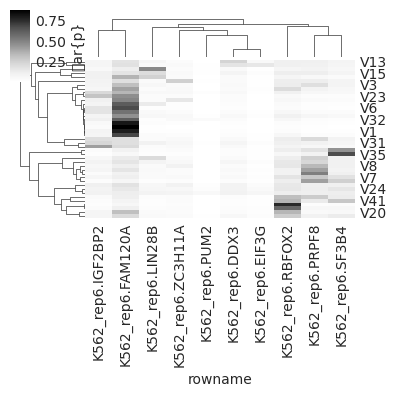

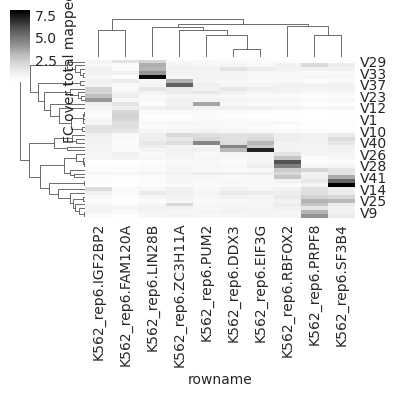

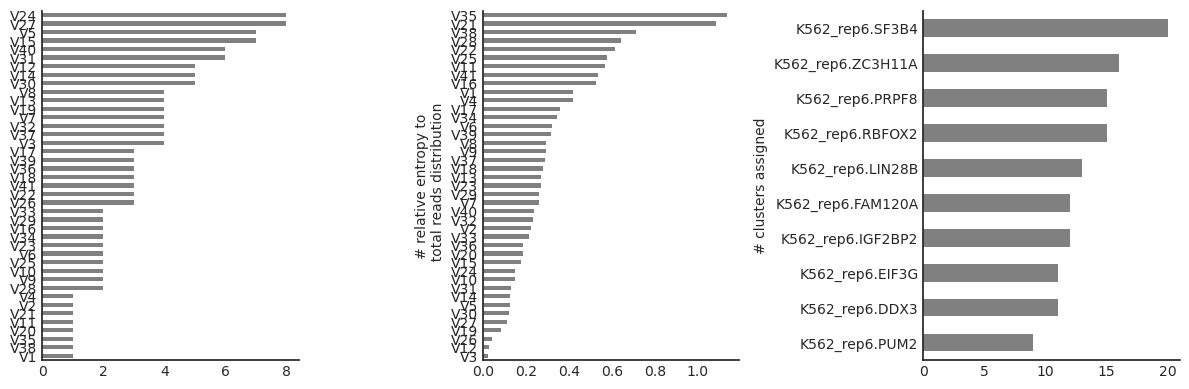

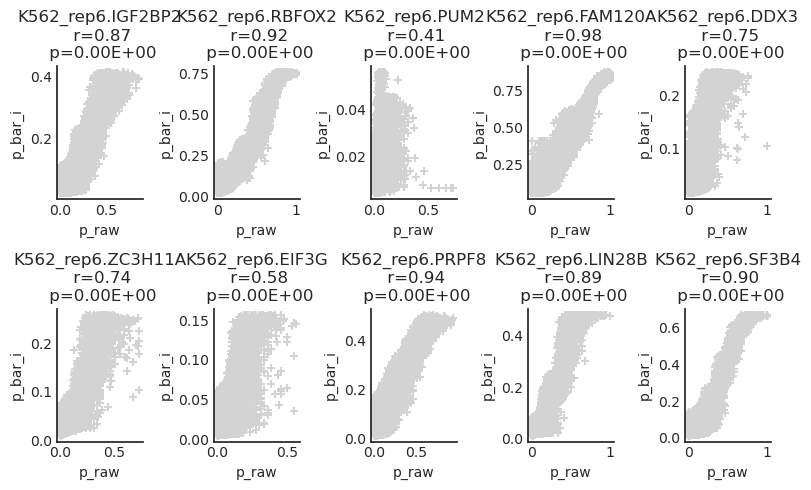

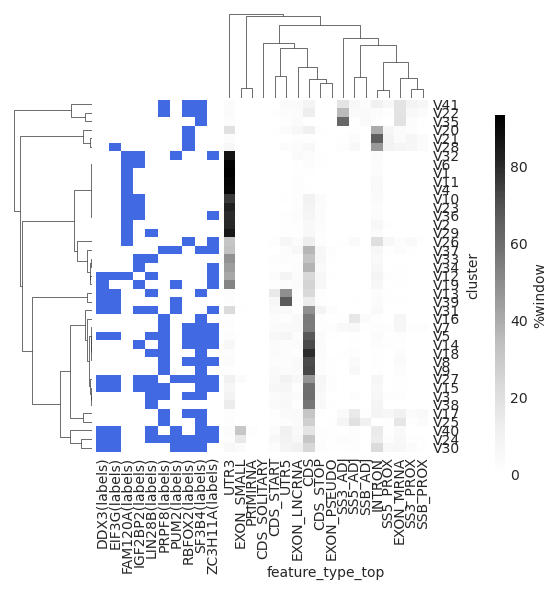

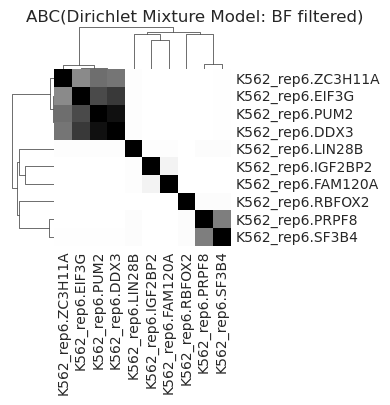

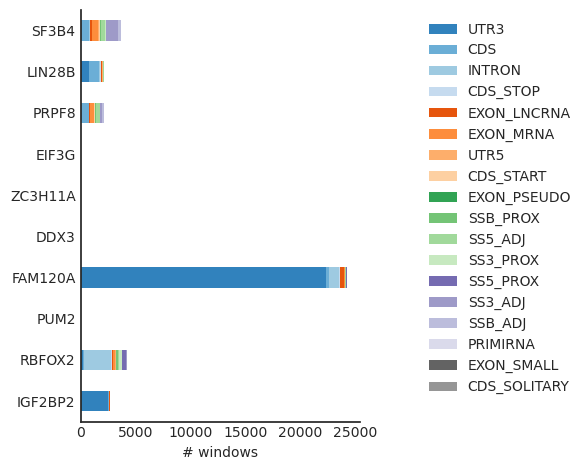

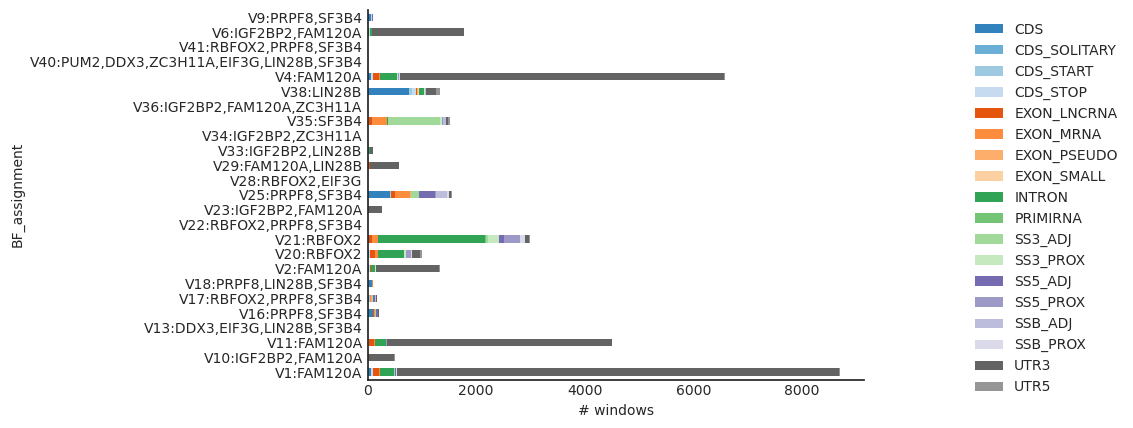

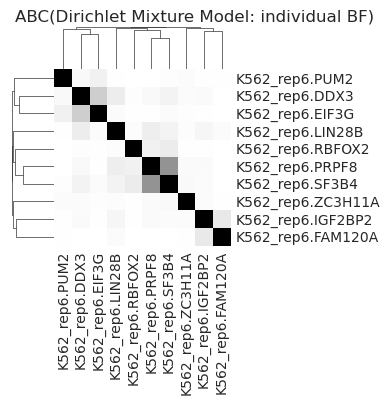

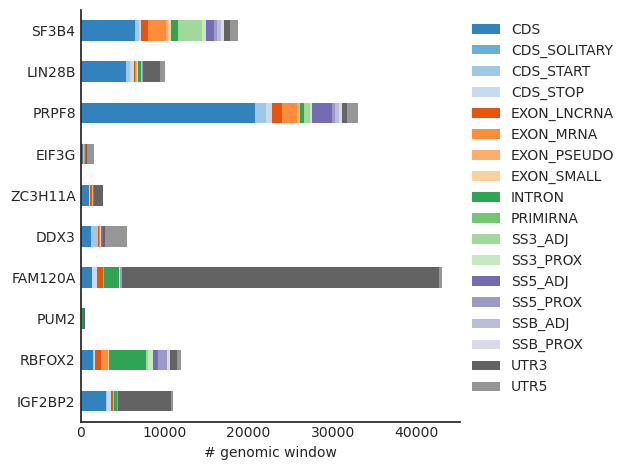

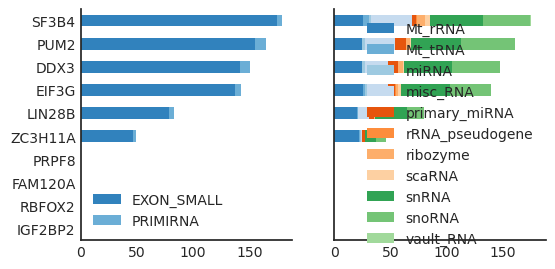

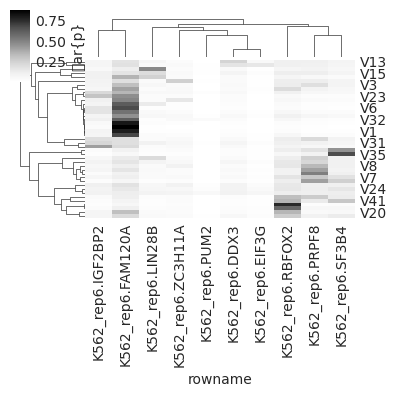

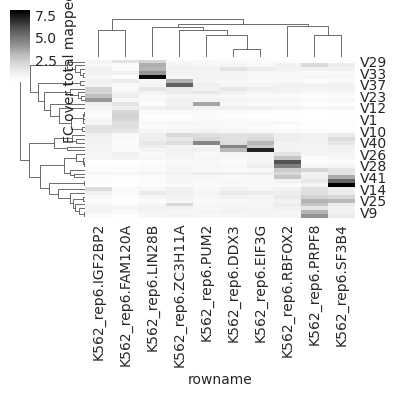

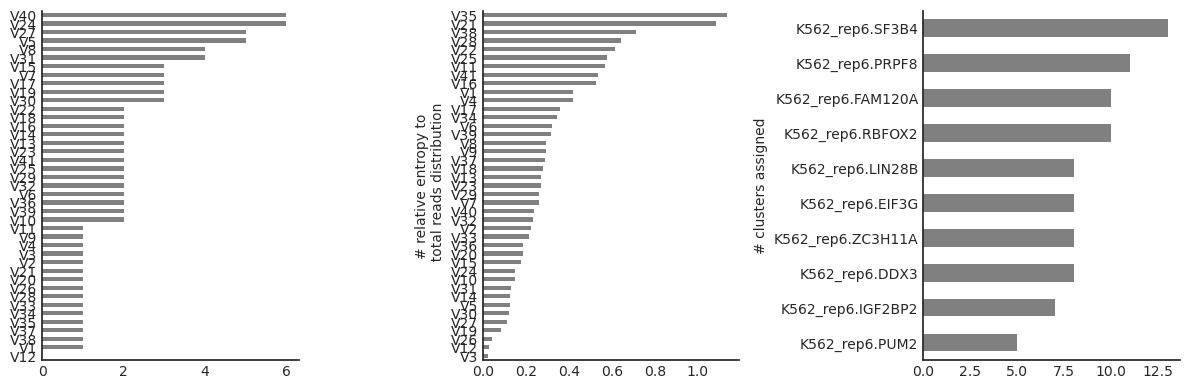

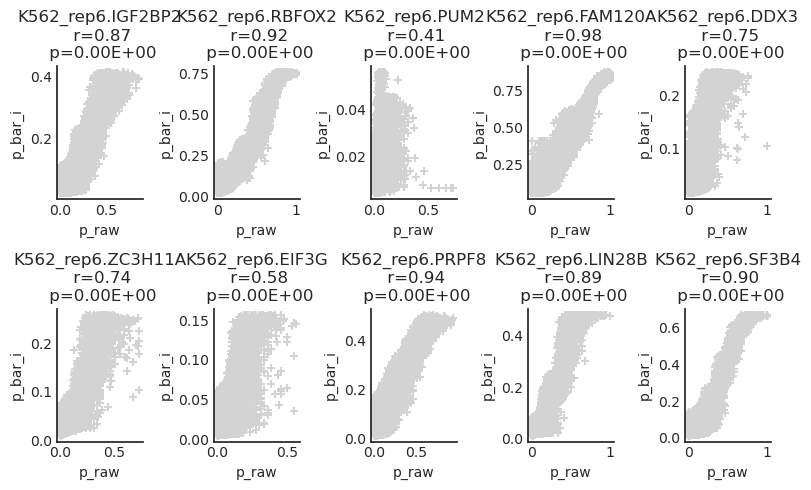

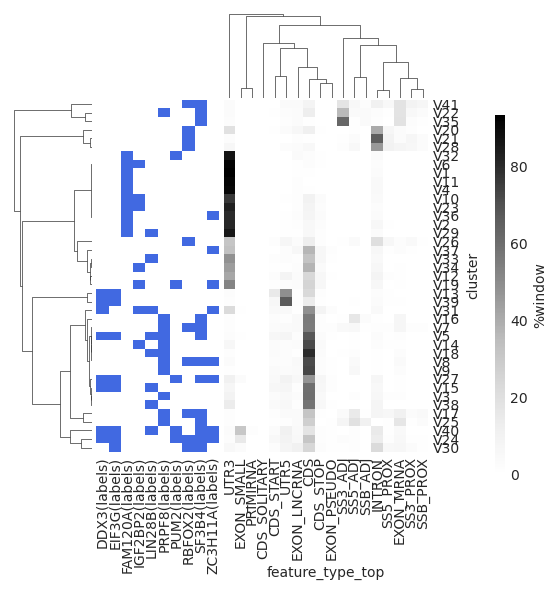

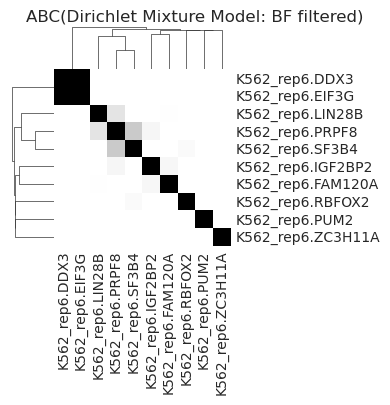

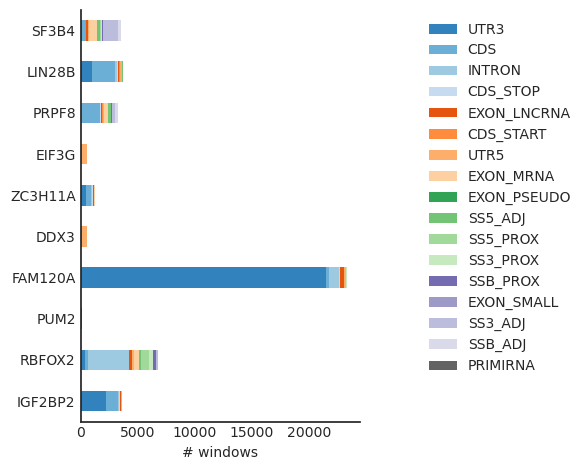

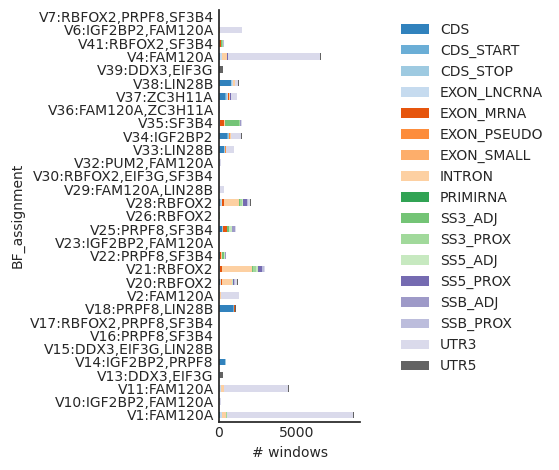

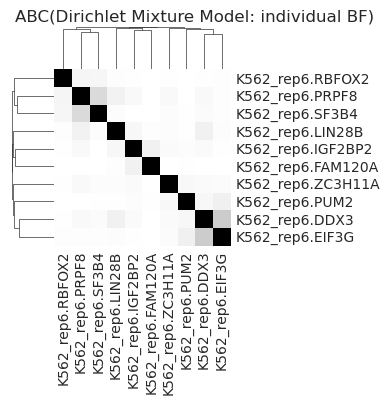

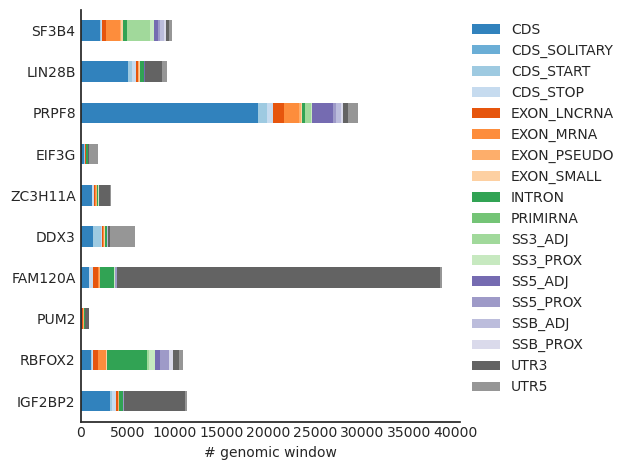

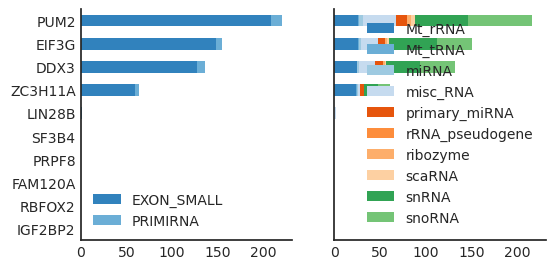

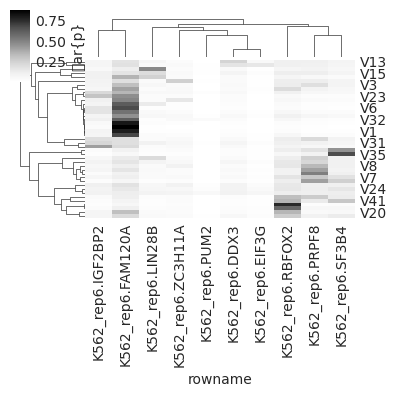

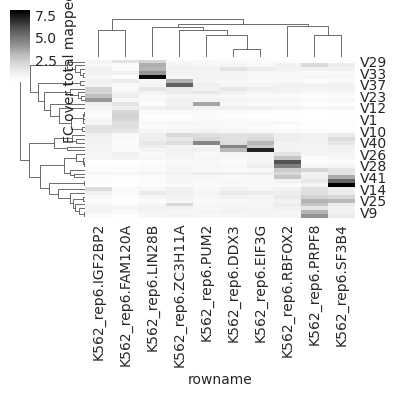

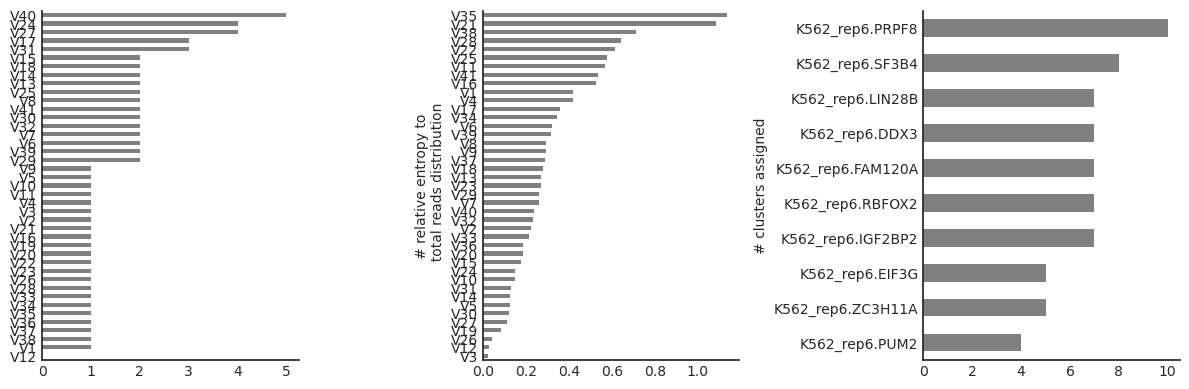

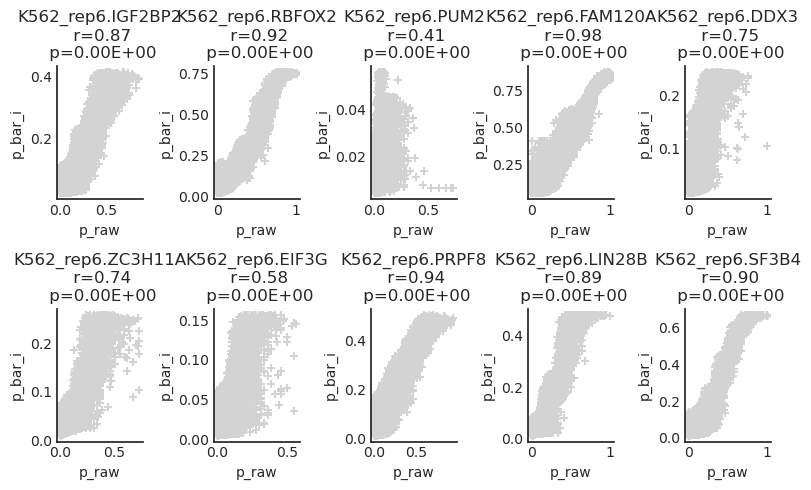

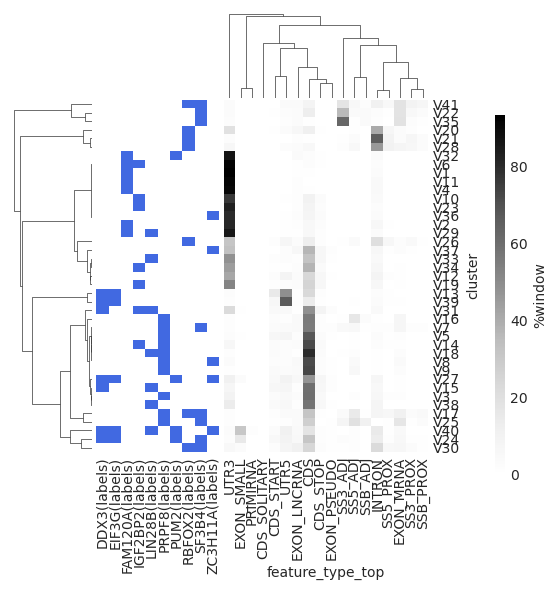

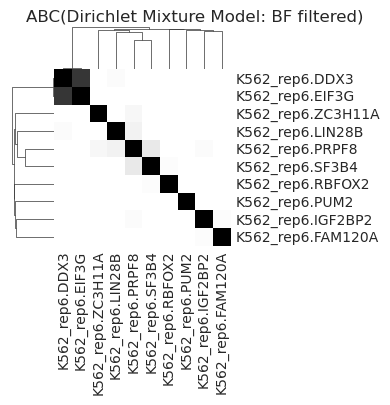

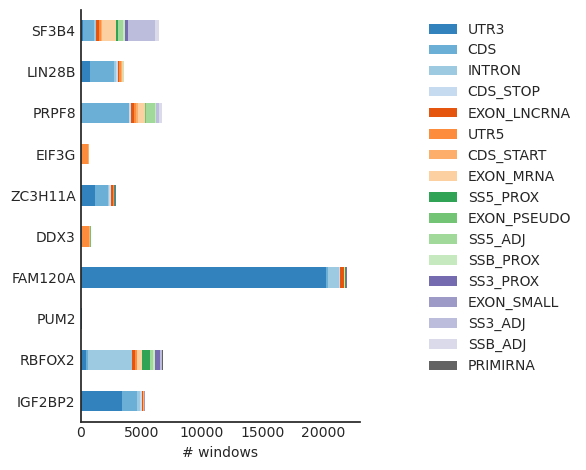

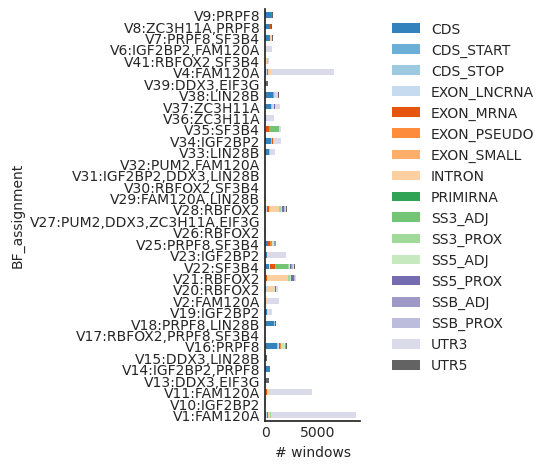

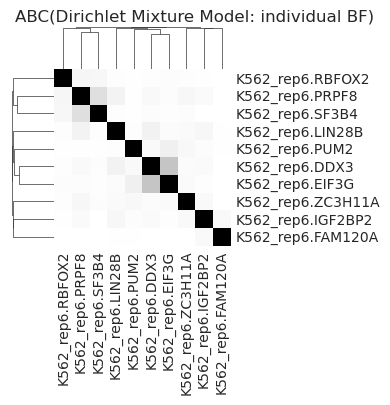

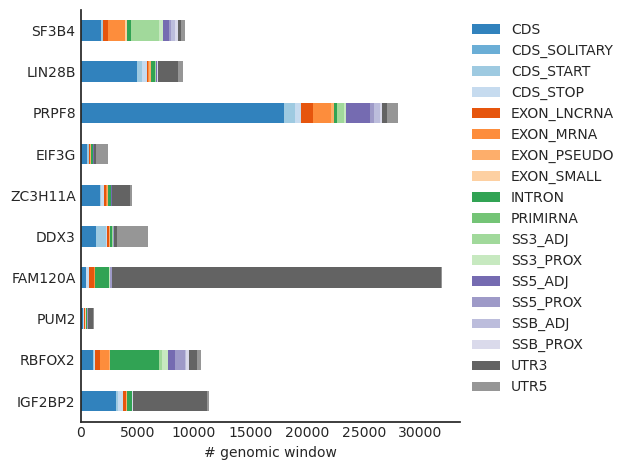

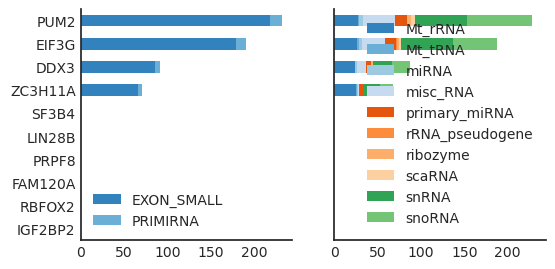

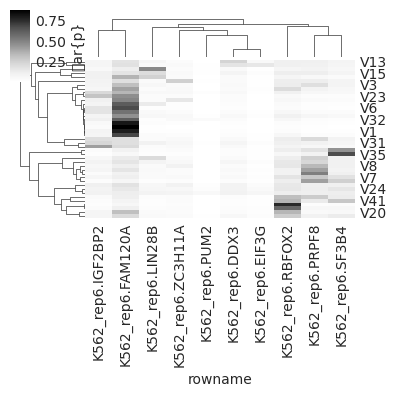

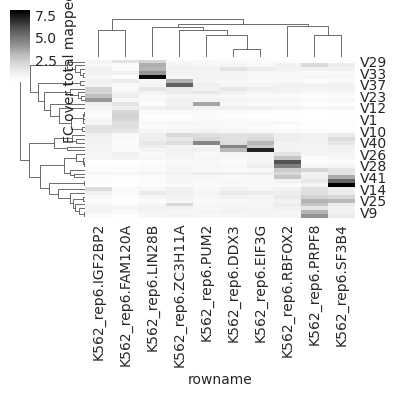

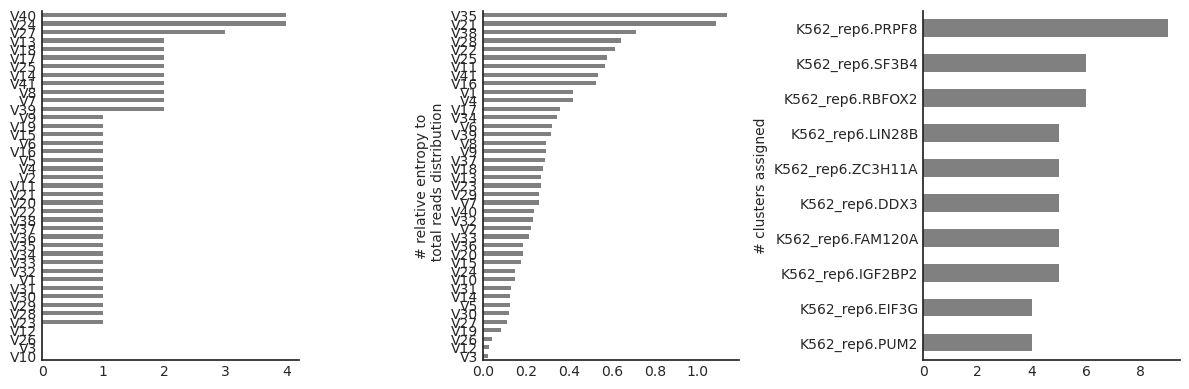

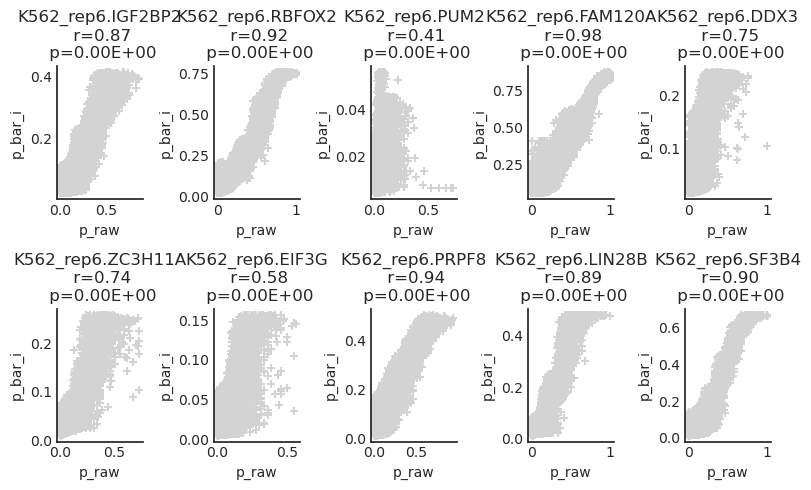

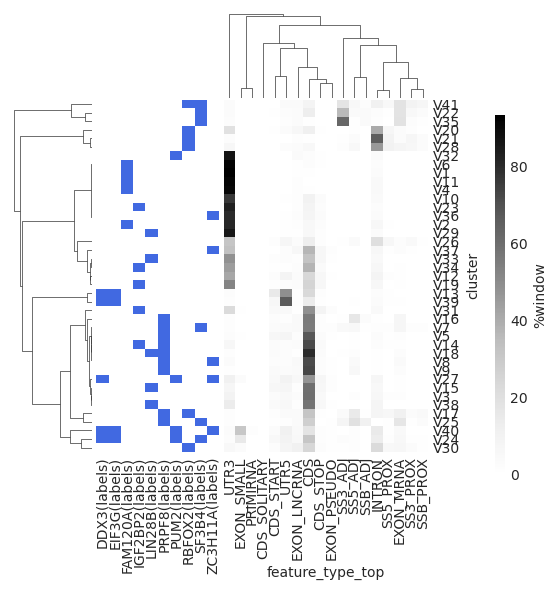

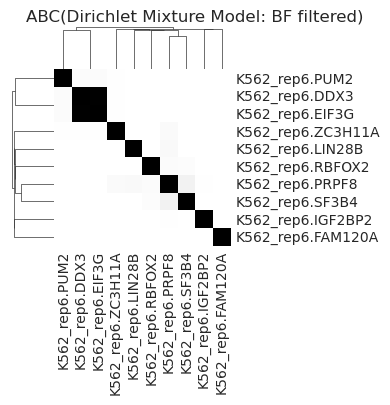

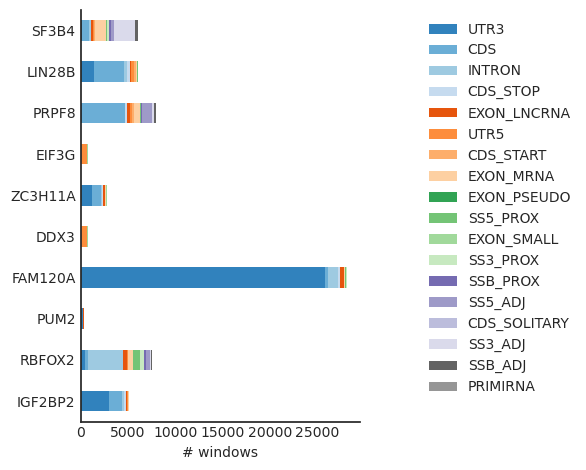

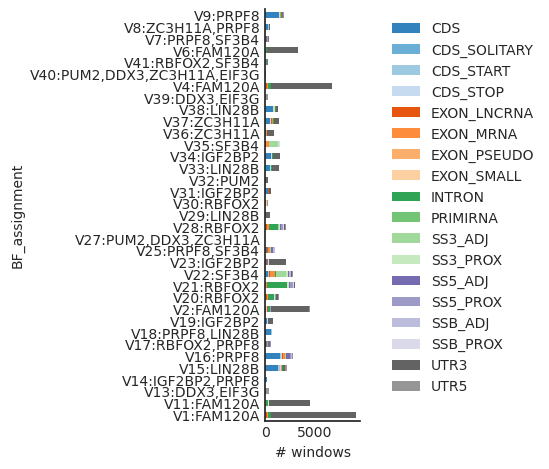

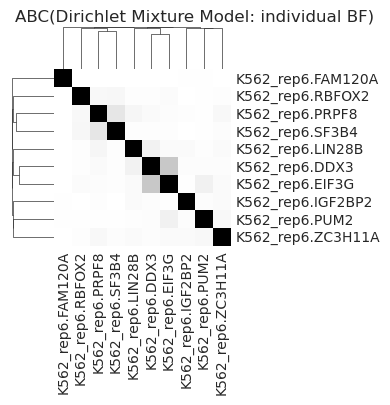

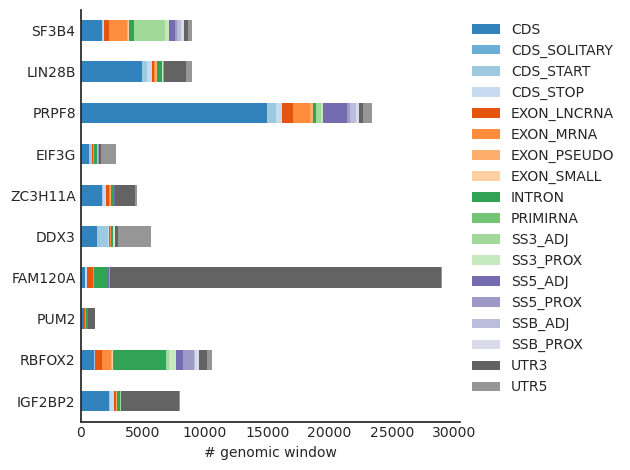

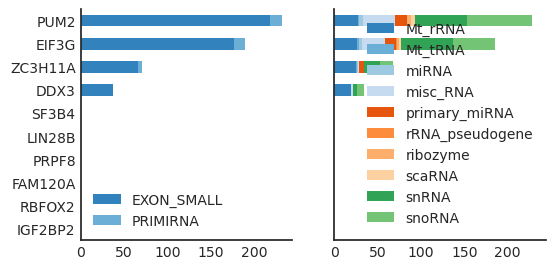

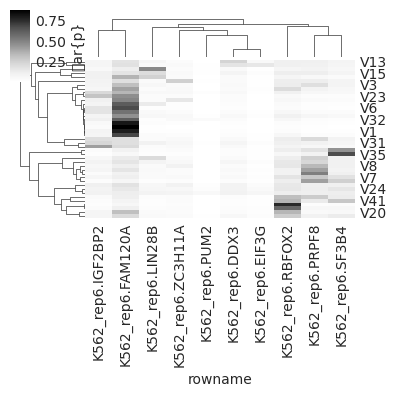

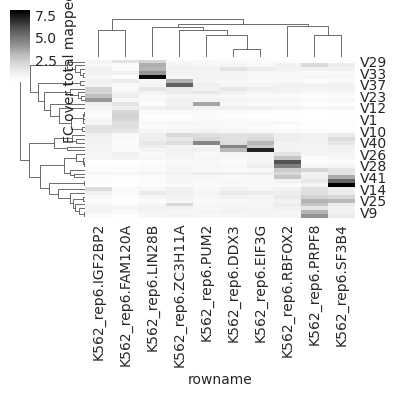

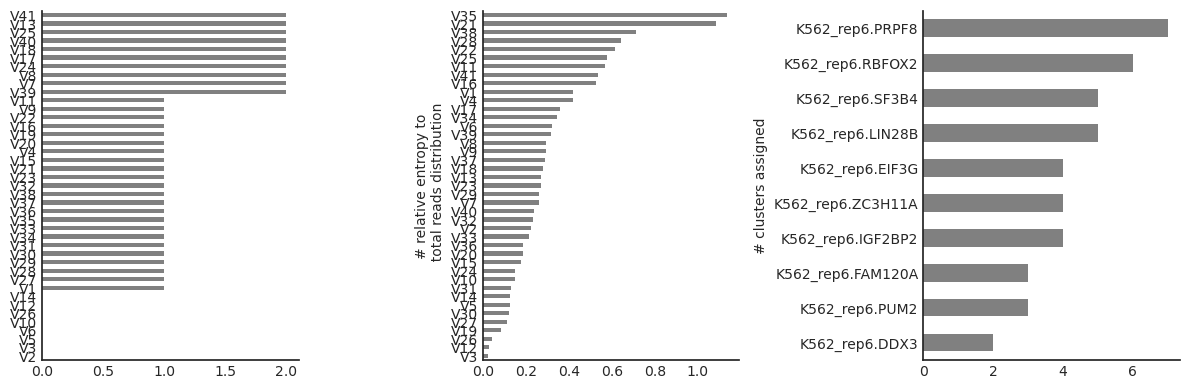

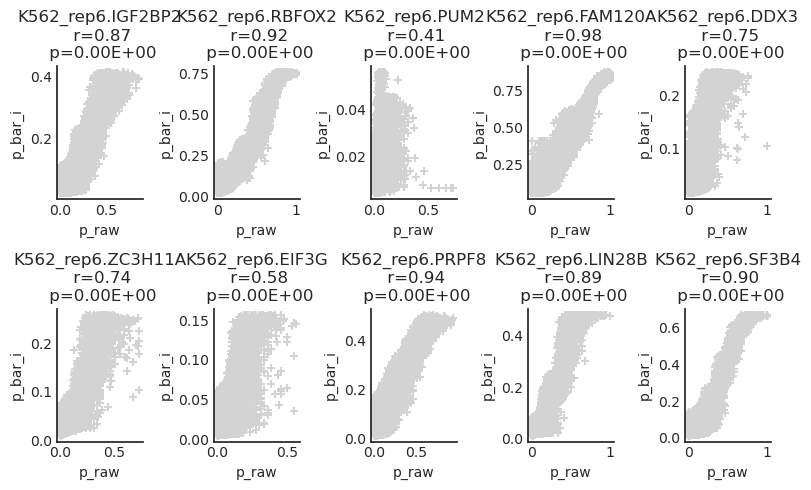

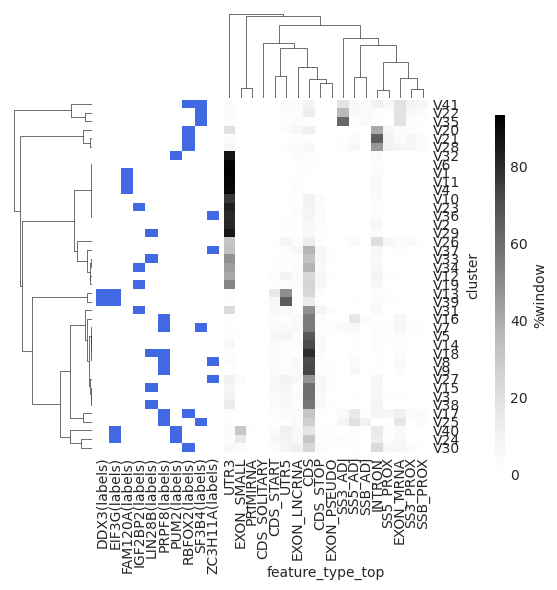

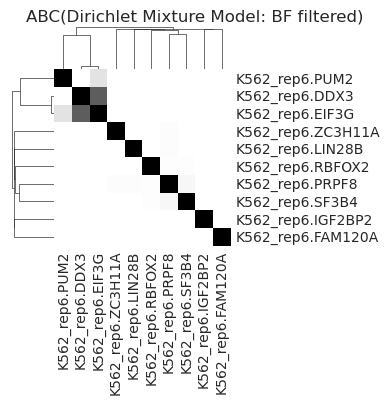

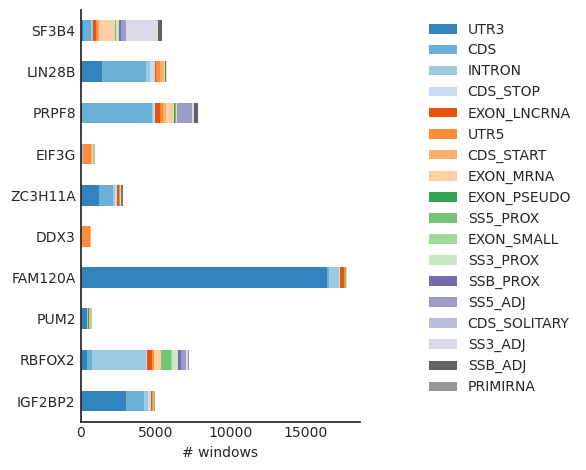

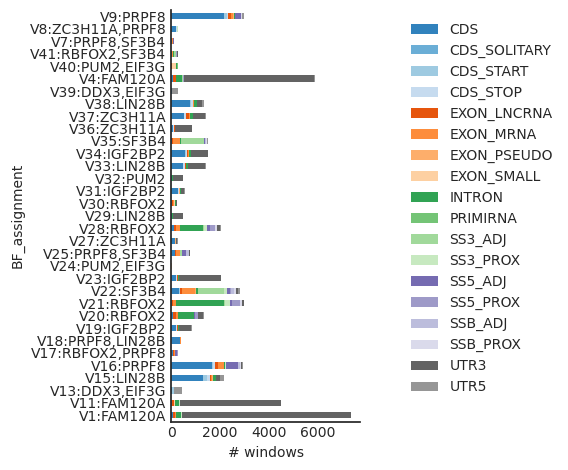

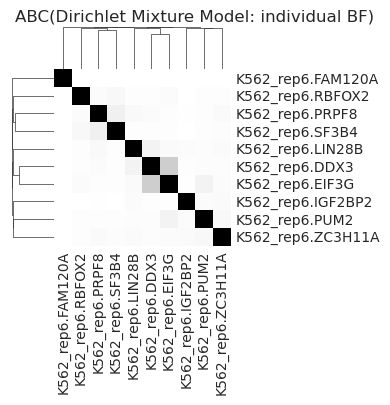

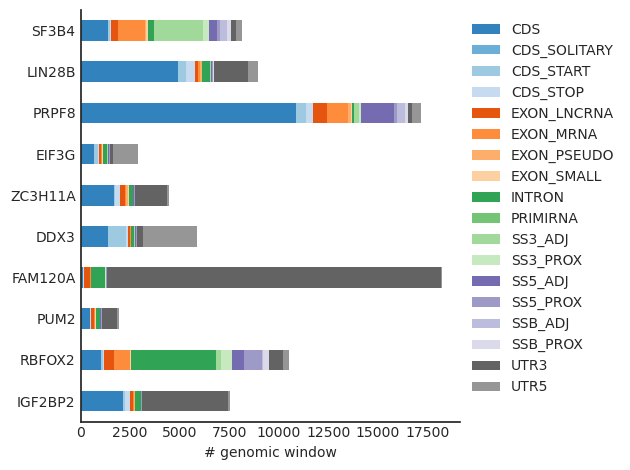

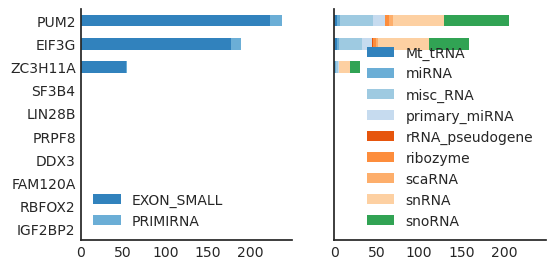

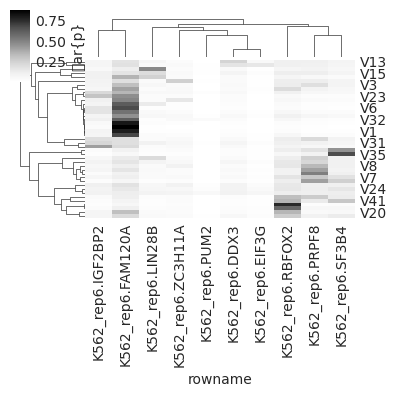

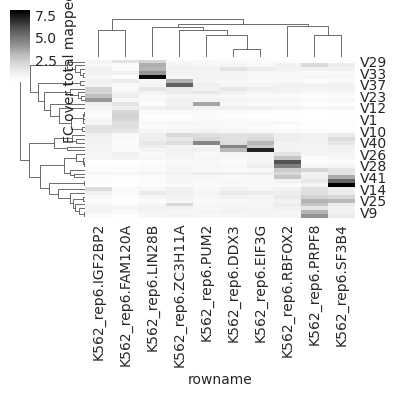

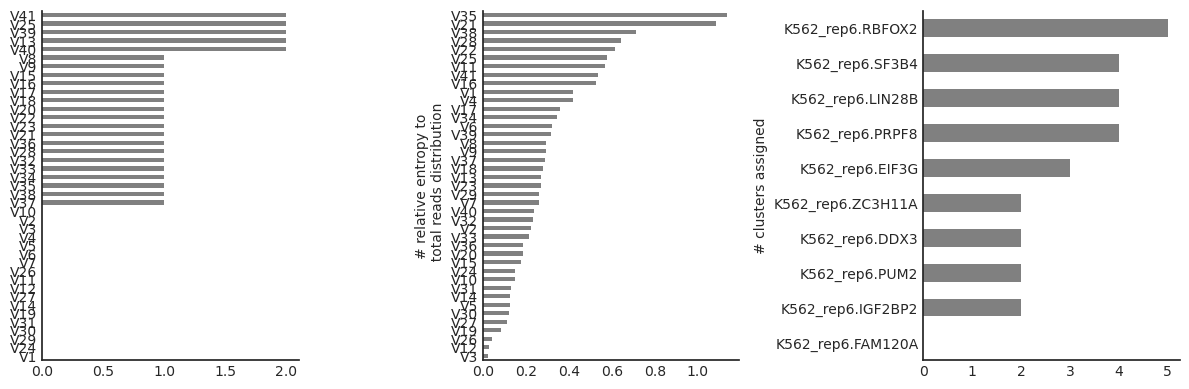

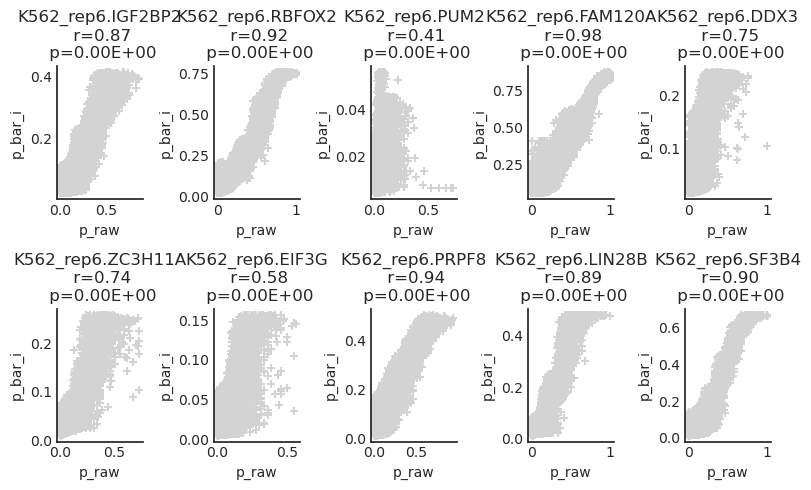

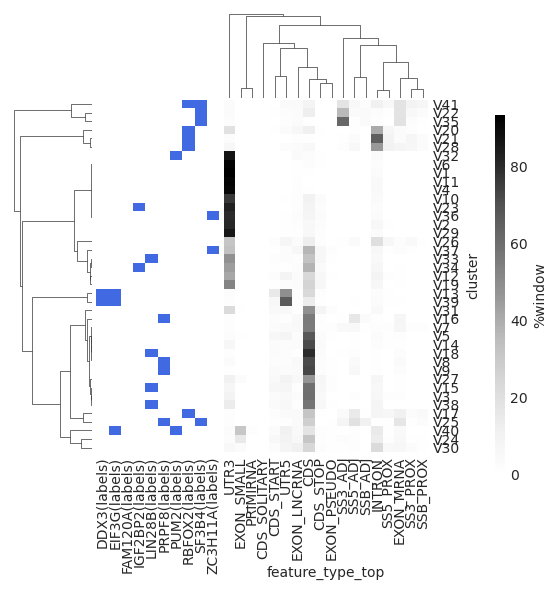

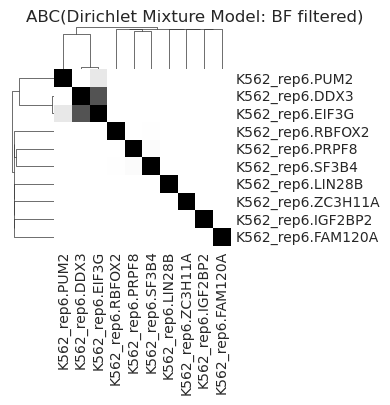

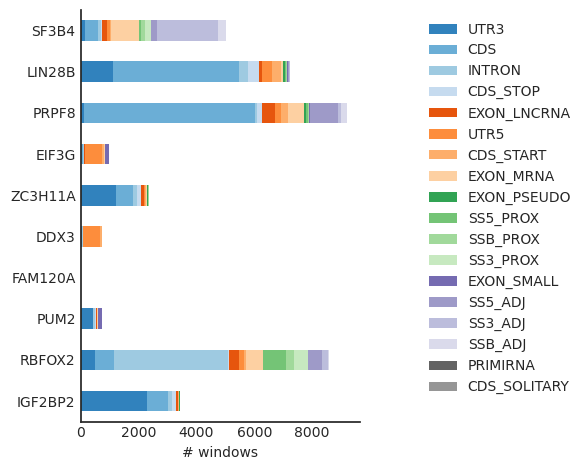

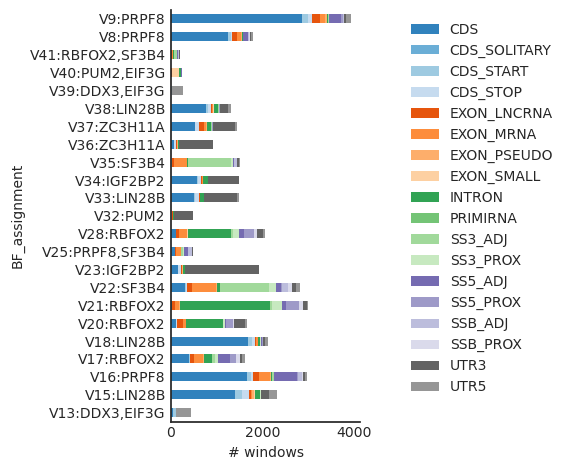

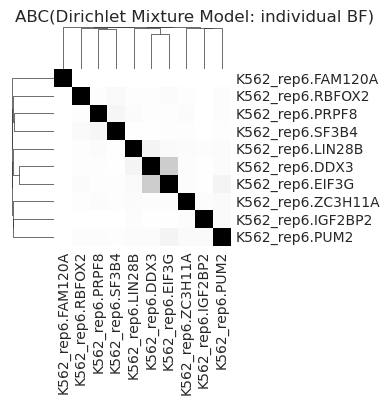

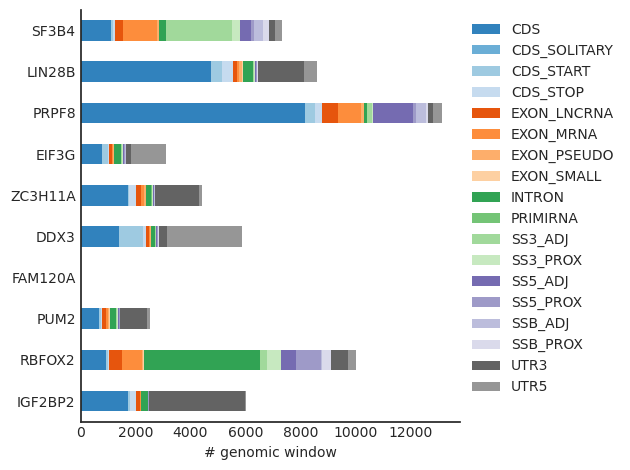

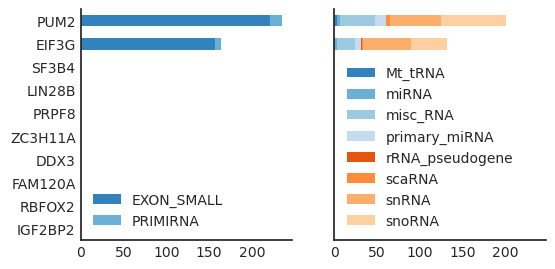

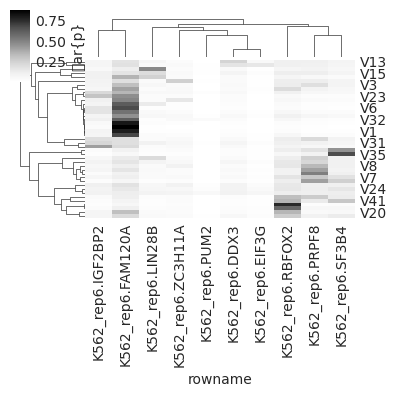

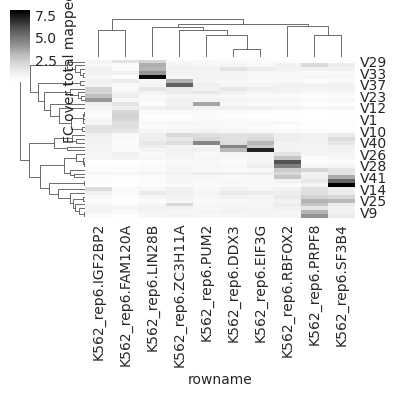

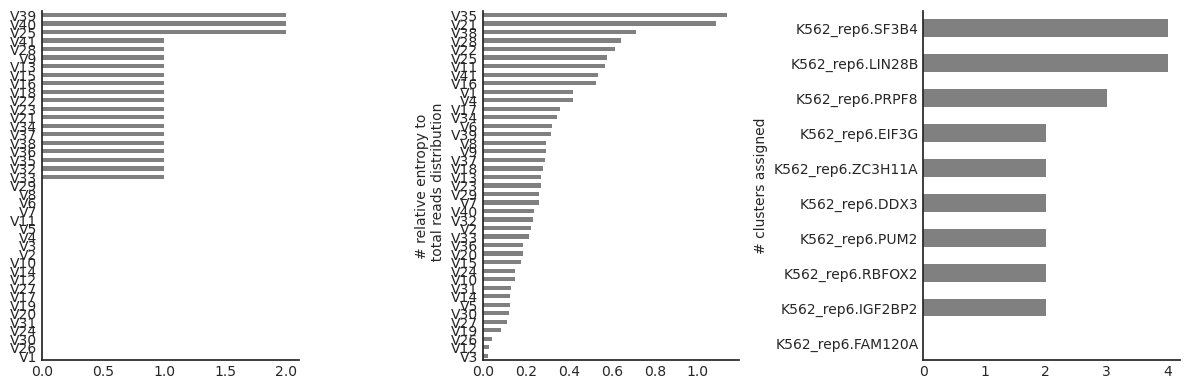

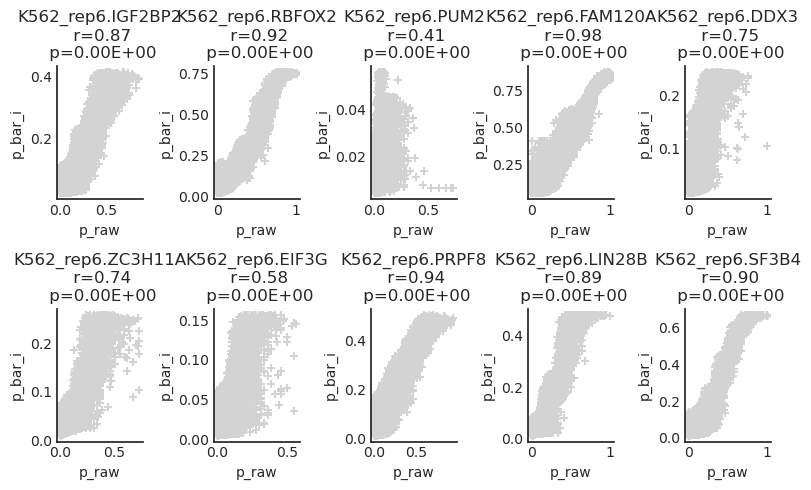

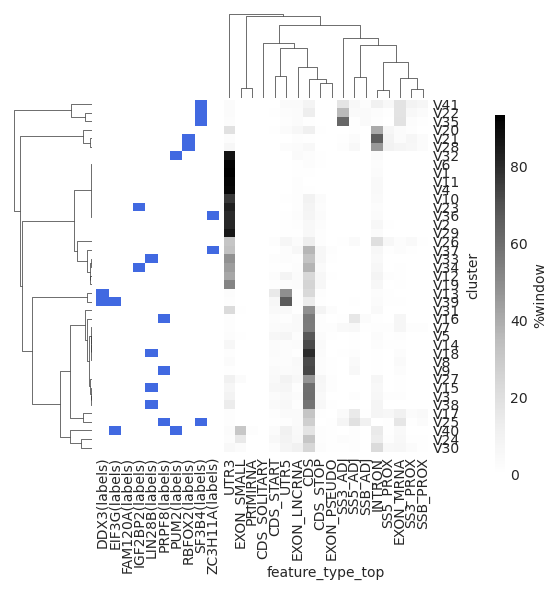

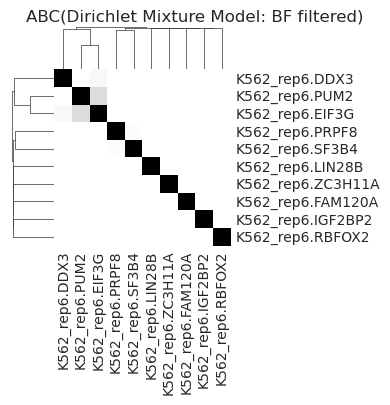

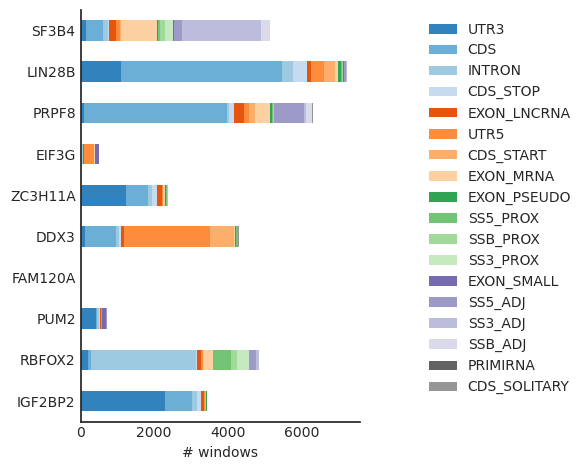

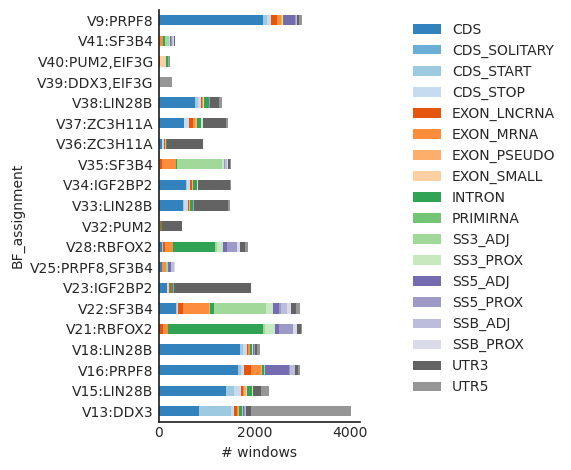

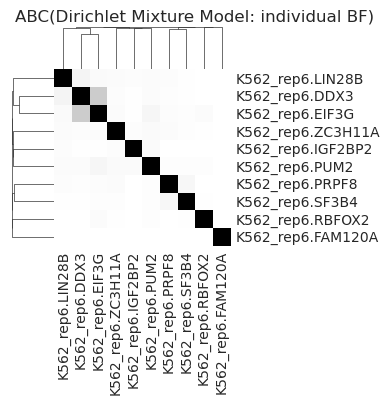

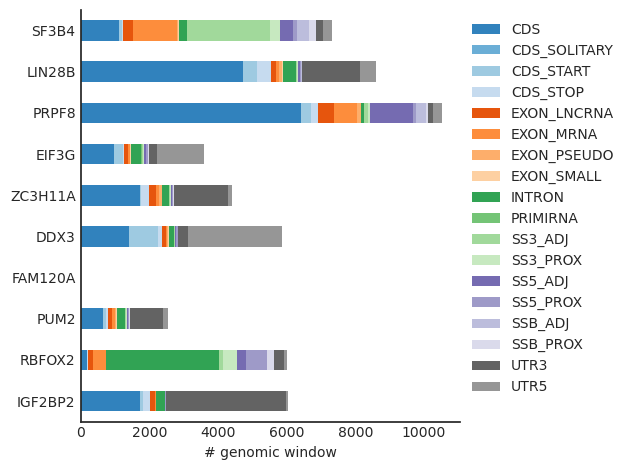

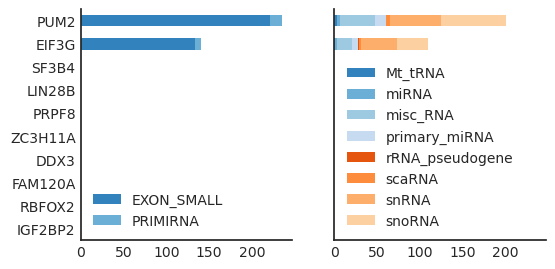

In [18]:
for fc in [1, 1.25, 1.5, 1.75, 2, 2.5, 3]:
    analyze_dmm_prefix(dmm_param_dir, f'K562_rep6.9', fc_raw_thres = fc)